## Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from typing import Tuple
import sys
from pathlib import Path
from datetime import datetime
import os

# Add parent directory to path to import Models
# This works for notebooks in the Experiments folder
project_root = Path.cwd().parent if Path.cwd().name == 'Experiments' else Path.cwd()
sys.path.insert(0, str(project_root))

# Setup results directory
results_dir = project_root / "results" / "sample_size"
results_dir.mkdir(parents=True, exist_ok=True)
plots_dir = results_dir / "plots"
plots_dir.mkdir(exist_ok=True)
stats_dir = results_dir / "statistics"
stats_dir.mkdir(exist_ok=True)

print(f"Results will be saved to: {results_dir}")

# Import from Models folder (note: no .py extension needed)
from Models.MC_Dropout import (
    MCDropoutRegressor,
    train_model,
    mc_dropout_predict,
    gaussian_nll,
    beta_nll,
    plot_toy_data,
    plot_uncertainties,
    normalize_x,
    normalize_x_data
)



## Genarte toy data sets

In [ ]:
# Reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# ----- Data generation for linear function with homo/heteroscedastic noise -----
# f(x) = 0.7x + 0.5
# noise_type: 'homoscedastic' (σ(x) = 0.20) or 'heteroscedastic' (σ(x) = 0.10 + 0.2(0.5 + 0.5sin(x)))
def generate_toy_regression(n_train=1000, train_range=(0.0, 10.0), 
                           grid_points=600, noise_type='heteroscedastic', type = "linear"):
    low, high = train_range
    x_train = np.random.uniform(low, high, size=(n_train, 1))
    
    if type == "linear":
        # Linear function: f(x) = 0.7x + 0.5
        f_clean = lambda x: 0.7 * x + 0.5
        y_clean_train = f_clean(x_train)
    elif type == "sin":
        f_clean = lambda x: x * np.sin(x) + x
        y_clean_train = f_clean(x_train)
    else:
        raise ValueError("type must be 'linear', 'sin'")

    # Define noise variance σ²(x)
    if noise_type == 'homoscedastic':
        # Homoscedastic: σ(x) = 0.8
        sigma = 0.8
        sigma_train = np.full_like(x_train, sigma)
    elif noise_type == 'heteroscedastic':
        # Heteroscedastic: 
        sigma_train = np.abs(0.5* x_train)
    else:
        raise ValueError("noise_type must be 'homoscedastic' or 'heteroscedastic'")
    
    # Generate noise: ε | x ~ N(0, σ²(x))
    epsilon = np.random.normal(0.0, sigma_train, size=(n_train, 1))
    y_train = y_clean_train + epsilon

    # Dense evaluation grid within training range
    x_grid = np.linspace(train_range[0], train_range[1], grid_points).reshape(-1, 1)
    y_grid_clean = f_clean(x_grid)

    return (x_train.astype(np.float32), y_train.astype(np.float32),
            x_grid.astype(np.float32), y_grid_clean.astype(np.float32))

In [ ]:
def plot_toy_data(x_train, y_train, x_grid, y_clean, title="Toy Regression Data", save_plot_file=True):
    """Plot the training data and clean function"""
    fig = plt.figure(figsize=(12, 6))
    
    # Plot training data points
    plt.scatter(x_train, y_train, alpha=0.6, s=20, label="Training data", color='blue')
    
    # Plot clean function
    plt.plot(x_grid, y_clean, 'r--', linewidth=2, label="Clean f(x) = 0.7x + 0.5")
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot if requested
    if save_plot_file:
        save_plot(fig, title, subfolder='toy_data')
    
    plt.show()
    plt.close(fig)

In [ ]:
# Polynomial function with homoscedastic noise
x_train_homo, y_train_homo, x_grid_homo, y_clean_homo = generate_toy_regression(
    n_train=1000, 
    train_range=(-10, 10), 
    noise_type='homoscedastic',
    type = "sin"
)

# Polynomial function with heteroscedastic noise (default - used in most experiments)
x_train, y_train, x_grid, y_clean = generate_toy_regression(
    n_train=1000, 
    train_range=(-10, 10), 
    noise_type='heteroscedastic',
    type = "sin"
)

In [ ]:
plot_toy_data(x_train_homo, y_train_homo, x_grid_homo, y_clean_homo, title="Toy Regression Data Homescedastic (n=1000)")

In [ ]:
plot_toy_data(x_train, y_train, x_grid, y_clean, title="Toy Regression Data Heteroscedastic (n=1000)")

## Function to plot uncertanties

In [ ]:
# Simplified plotting function without OOD
def plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_clean, mu_pred, ale_var, epi_var, tot_var, title, noise_type='heteroscedastic', func_type=''):
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    x = x_grid[:, 0]
    
    # Plot 1: Predictive mean + Total uncertainty
    axes[0].scatter(x_train_subset[:, 0], y_train_subset[:, 0], alpha=0.6, s=20, color='blue', label="Training data", zorder=3)
    axes[0].plot(x, mu_pred, 'b-', linewidth=2, label="Predictive mean")
    axes[0].fill_between(x, mu_pred - np.sqrt(tot_var), mu_pred + np.sqrt(tot_var), 
                        alpha=0.3, color='blue', label="±σ(total)")
    axes[0].plot(x, y_clean[:, 0], 'r--', linewidth=1.5, alpha=0.8, label="Clean f(x) = 0.7x + 0.5")
    axes[0].set_ylabel("y")
    axes[0].set_title(f"{title}: Predictive Mean + Total Uncertainty")
    axes[0].legend(loc="upper left")
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Predictive mean + Aleatoric uncertainty only
    axes[1].scatter(x_train_subset[:, 0], y_train_subset[:, 0], alpha=0.6, s=20, color='blue', label="Training data", zorder=3)
    axes[1].plot(x, mu_pred, 'b-', linewidth=2, label="Predictive mean")
    axes[1].fill_between(x, mu_pred - np.sqrt(ale_var), mu_pred + np.sqrt(ale_var), 
                        alpha=0.3, color='green', label="±σ(aleatoric)")
    axes[1].plot(x, y_clean[:, 0], 'r--', linewidth=1.5, alpha=0.8, label="Clean f(x) = 0.7x + 0.5")
    axes[1].set_ylabel("y")
    axes[1].set_title(f"{title}: Predictive Mean + Aleatoric Uncertainty")
    axes[1].legend(loc="upper left")
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Predictive mean + Epistemic uncertainty only
    axes[2].scatter(x_train_subset[:, 0], y_train_subset[:, 0], alpha=0.6, s=20, color='blue', label="Training data", zorder=3)
    axes[2].plot(x, mu_pred, 'b-', linewidth=2, label="Predictive mean")
    axes[2].fill_between(x, mu_pred - np.sqrt(epi_var), mu_pred + np.sqrt(epi_var), 
                        alpha=0.3, color='orange', label="±σ(epistemic)")
    axes[2].plot(x, y_clean[:, 0], 'r--', linewidth=1.5, alpha=0.8, label="Clean f(x) = 0.7x + 0.5")
    axes[2].set_ylabel("y")
    axes[2].set_xlabel("x")
    axes[2].set_title(f"{title}: Predictive Mean + Epistemic Uncertainty")
    axes[2].legend(loc="upper left")
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    
    # Save plot with organized folder structure: uncertainties/{noise_type}/{func_type}/
    subfolder = f"uncertainties/{noise_type}/{func_type}" if func_type else f"uncertainties/{noise_type}"
    save_plot(fig, title, subfolder=subfolder)
    
    plt.show()
    plt.close(fig)


In [ ]:
## Utility functions for saving results

def sanitize_filename(name):
    """Convert a string to a valid filename"""
    # Replace invalid characters with underscores
    invalid_chars = '<>:"/\\|?*'
    for char in invalid_chars:
        name = name.replace(char, '_')
    # Replace spaces with underscores and remove multiple underscores
    name = '_'.join(name.split())
    return name

def save_plot(fig, filename, subfolder=''):
    """Save a matplotlib figure to the results/plots directory"""
    if subfolder:
        save_dir = plots_dir / subfolder
        save_dir.mkdir(parents=True, exist_ok=True)
    else:
        save_dir = plots_dir
    
    filepath = save_dir / f"{sanitize_filename(filename)}.png"
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved plot: {filepath}")
    return filepath

def save_statistics(data_dict, filename, subfolder='', save_excel=True):
    """Save statistics dictionary to CSV and optionally Excel"""
    if subfolder:
        save_dir = stats_dir / subfolder
        save_dir.mkdir(parents=True, exist_ok=True)
    else:
        save_dir = stats_dir
    
    # Convert to DataFrame if it's a dict
    if isinstance(data_dict, dict):
        df = pd.DataFrame(data_dict)
    else:
        df = data_dict
    
    # Save as CSV
    csv_filepath = save_dir / f"{sanitize_filename(filename)}.csv"
    df.to_csv(csv_filepath, index=False)
    print(f"Saved statistics (CSV): {csv_filepath}")
    
    # Save as Excel if requested
    if save_excel:
        try:
            excel_filepath = save_dir / f"{sanitize_filename(filename)}.xlsx"
            df.to_excel(excel_filepath, index=False, engine='openpyxl')
            print(f"Saved statistics (Excel): {excel_filepath}")
            return csv_filepath, excel_filepath
        except ImportError:
            print("Warning: openpyxl not available. Excel file not saved. Only CSV saved.")
            print("Install openpyxl with: pip install openpyxl")
            return csv_filepath
    
    return csv_filepath

def save_summary_text(text, filename, subfolder=''):
    """Save summary text to a file"""
    if subfolder:
        save_dir = stats_dir / subfolder
        save_dir.mkdir(parents=True, exist_ok=True)
    else:
        save_dir = stats_dir
    
    filepath = save_dir / f"{sanitize_filename(filename)}.txt"
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(text)
    print(f"Saved summary: {filepath}")
    return filepath

def save_summary_statistics(percentages, avg_ale_norm_list, avg_epi_norm_list, 
                           avg_tot_norm_list, correlation_list, function_name, 
                           noise_type='heteroscedastic', func_type=''):
    """Helper function to save summary statistics and create summary plot
    
    Returns:
        tuple: (stats_df, fig) - DataFrame with statistics and matplotlib figure
    """
    # Create DataFrame with summary statistics
    stats_df = pd.DataFrame({
        'Percentage': percentages,
        'Avg_Aleatoric_norm': avg_ale_norm_list,
        'Avg_Epistemic_norm': avg_epi_norm_list,
        'Avg_Total_norm': avg_tot_norm_list,
        'Correlation_Epi_Ale': correlation_list
    })
    
    # Save statistics to CSV and Excel (Excel is saved automatically)
    save_statistics(stats_df, f"uncertainties_summary_{function_name}_{noise_type}", 
                    subfolder=f"{noise_type}/{func_type}", save_excel=True)
    
    # Create and save summary plots (uncertainties and correlations)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Normalized Average Uncertainties
    ax1.plot(percentages, avg_ale_norm_list, 'o-', linewidth=2, markersize=8, 
             label='Aleatoric Uncertainty', color='green')
    ax1.plot(percentages, avg_epi_norm_list, 's-', linewidth=2, markersize=8, 
             label='Epistemic Uncertainty', color='orange')
    ax1.plot(percentages, avg_tot_norm_list, '^-', linewidth=2, markersize=8, 
             label='Total Uncertainty', color='blue')
    ax1.set_xlabel('Training Data Percentage (%)', fontsize=12)
    ax1.set_ylabel('Normalized Average Uncertainty', fontsize=12)
    ax1.set_title(f'Normalized Average Uncertainties vs Training Data Percentage\n{function_name} Function ({noise_type.capitalize()})', 
                  fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 105)
    ax1.set_ylim(0, 1.05)
    
    # Plot 2: Correlation between Epistemic and Aleatoric Uncertainties
    ax2.plot(percentages, correlation_list, 'D-', linewidth=2, markersize=8, 
             label='Correlation (Epi-Ale)', color='purple')
    ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax2.set_xlabel('Training Data Percentage (%)', fontsize=12)
    ax2.set_ylabel('Correlation Coefficient', fontsize=12)
    ax2.set_title(f'Correlation: Epistemic vs Aleatoric Uncertainty\n{function_name} Function ({noise_type.capitalize()})', 
                  fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 105)
    ax2.set_ylim(-1.05, 1.05)
    
    plt.tight_layout()
    
    save_plot(fig, f"uncertainties_summary_{function_name}_{noise_type}", 
              subfolder=f"{noise_type}/{func_type}")
    
    return stats_df, fig


## Sample size Heteroscedastic


################################################################################
# Function Type: Linear (linear)
################################################################################


Training with 1% of training data (10 samples)
[beta_nll] Epoch 100/700 - avg loss 2.6780
[beta_nll] Epoch 200/700 - avg loss 1.6855
[beta_nll] Epoch 300/700 - avg loss 1.3863
[beta_nll] Epoch 400/700 - avg loss 1.0429
[beta_nll] Epoch 500/700 - avg loss 1.1659
[beta_nll] Epoch 600/700 - avg loss 0.8984
[beta_nll] Epoch 700/700 - avg loss 1.0714
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_1%_training_data.png


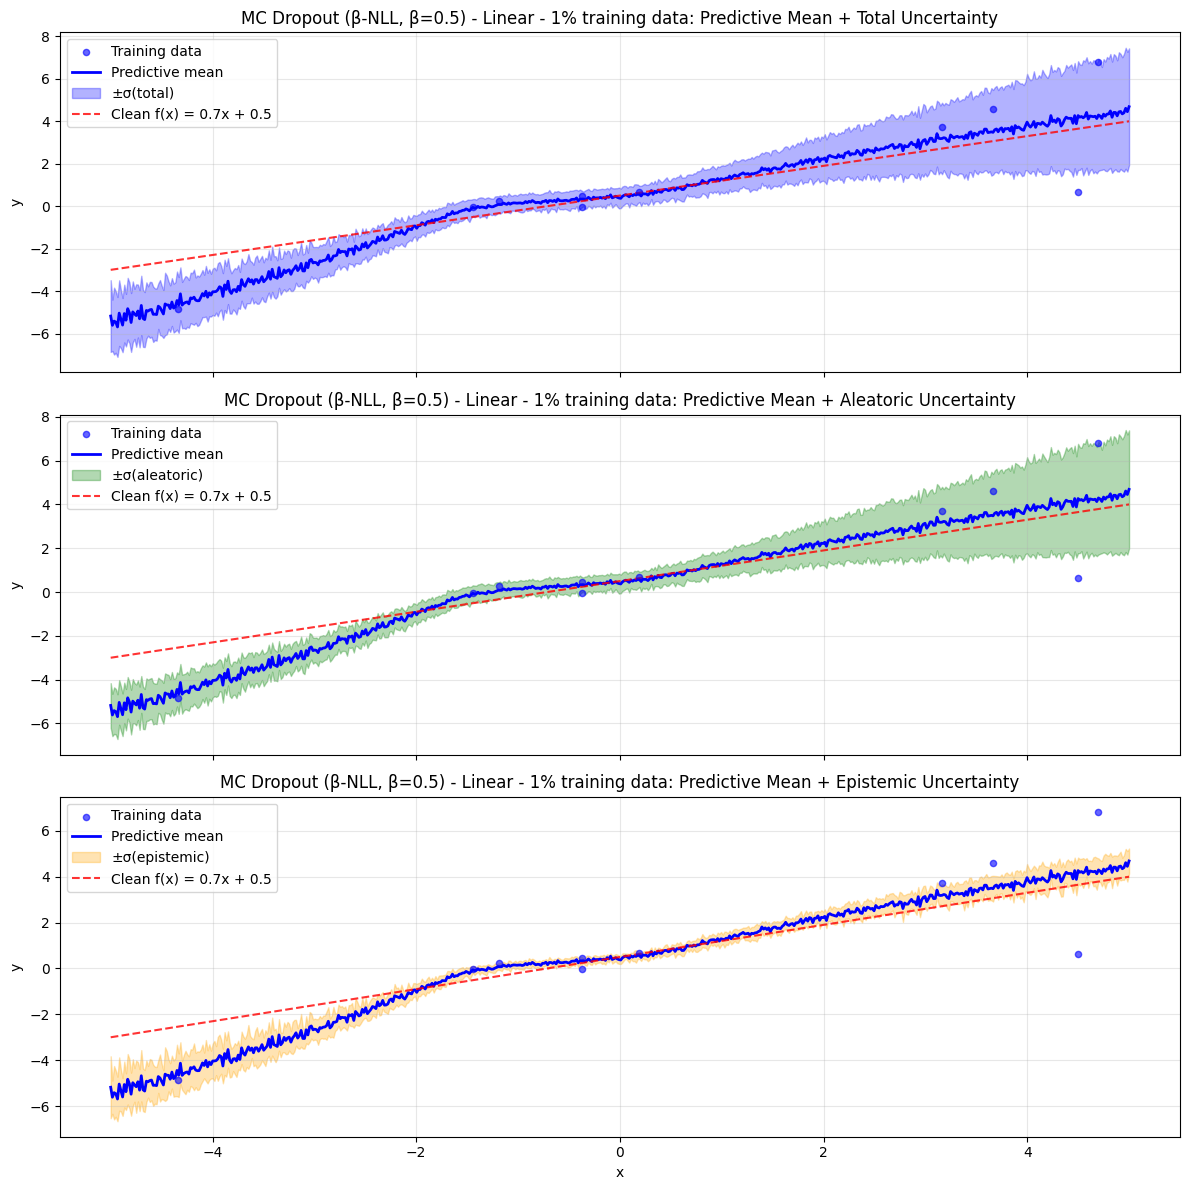


Training with 5% of training data (50 samples)
[beta_nll] Epoch 100/700 - avg loss 1.7960
[beta_nll] Epoch 200/700 - avg loss 1.7847
[beta_nll] Epoch 300/700 - avg loss 1.6761
[beta_nll] Epoch 400/700 - avg loss 1.7227
[beta_nll] Epoch 500/700 - avg loss 1.7647
[beta_nll] Epoch 600/700 - avg loss 1.7837
[beta_nll] Epoch 700/700 - avg loss 1.7251
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_5%_training_data.png


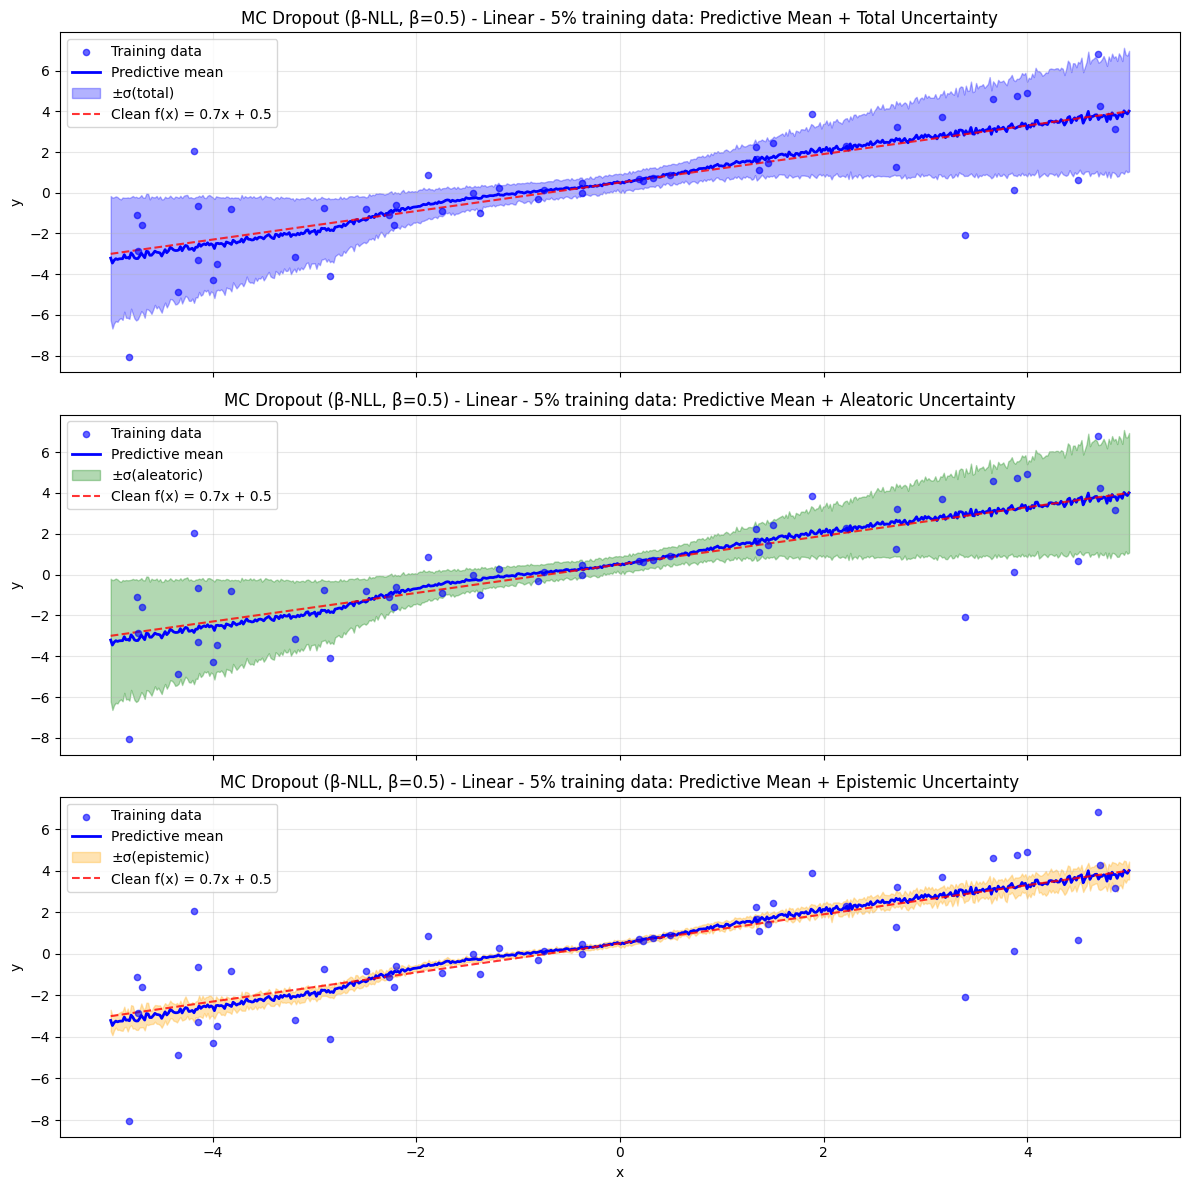


Training with 10% of training data (100 samples)
[beta_nll] Epoch 100/700 - avg loss 1.1591
[beta_nll] Epoch 200/700 - avg loss 1.1587
[beta_nll] Epoch 300/700 - avg loss 1.1539
[beta_nll] Epoch 400/700 - avg loss 1.2366
[beta_nll] Epoch 500/700 - avg loss 1.2265
[beta_nll] Epoch 600/700 - avg loss 1.0770
[beta_nll] Epoch 700/700 - avg loss 1.1713
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_10%_training_data.png


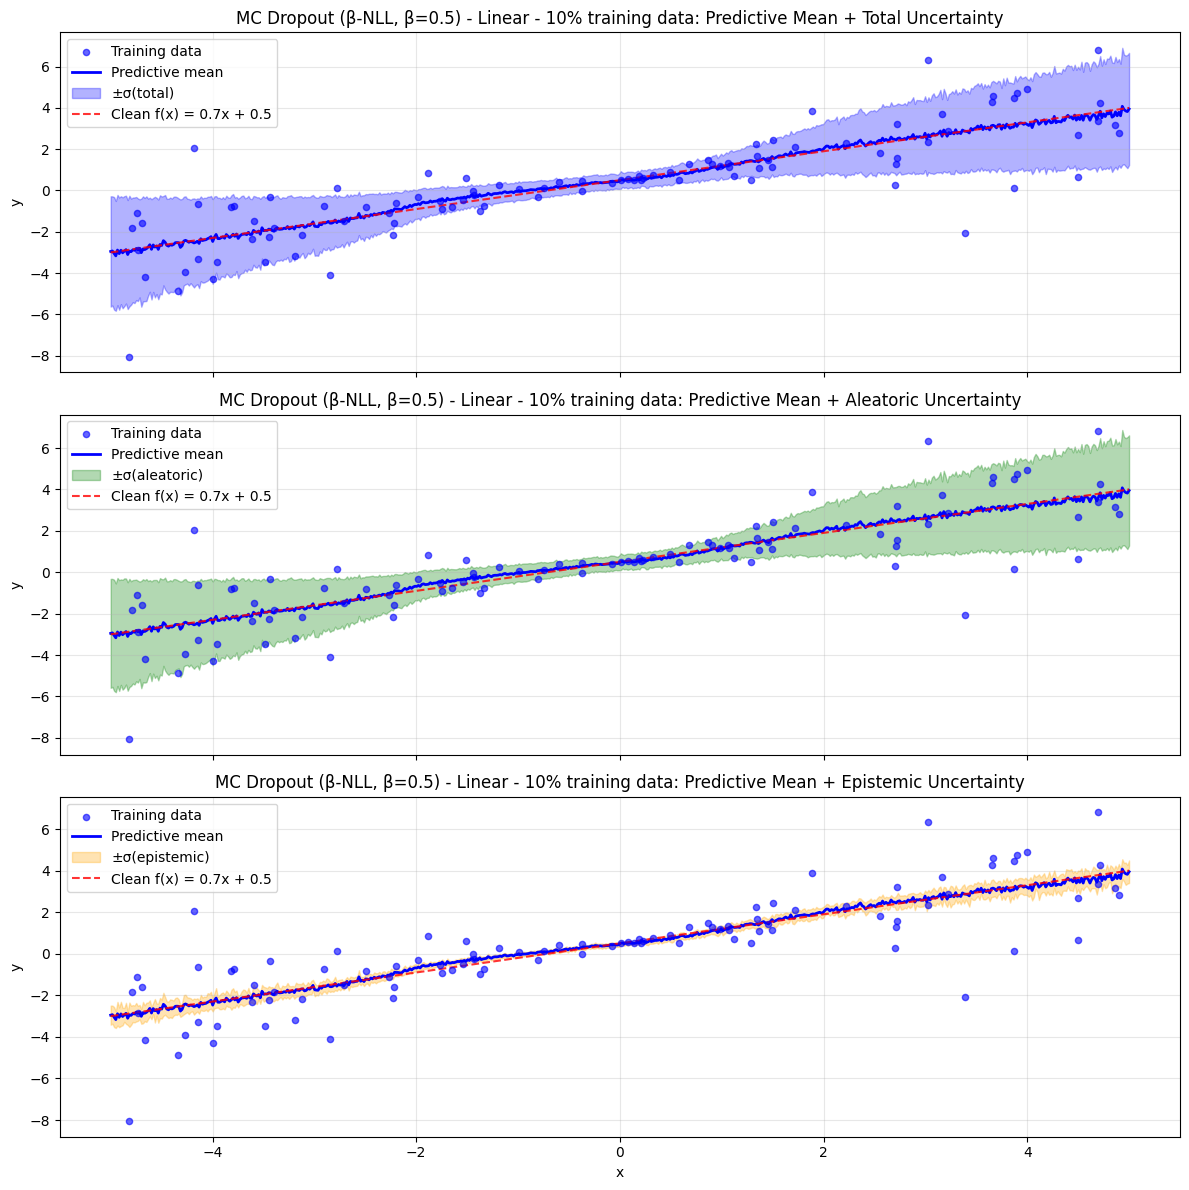


Training with 15% of training data (150 samples)
[beta_nll] Epoch 100/700 - avg loss 1.2258
[beta_nll] Epoch 200/700 - avg loss 1.2444
[beta_nll] Epoch 300/700 - avg loss 1.1704
[beta_nll] Epoch 400/700 - avg loss 1.1531
[beta_nll] Epoch 500/700 - avg loss 1.1953
[beta_nll] Epoch 600/700 - avg loss 1.1640
[beta_nll] Epoch 700/700 - avg loss 1.1266
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_15%_training_data.png


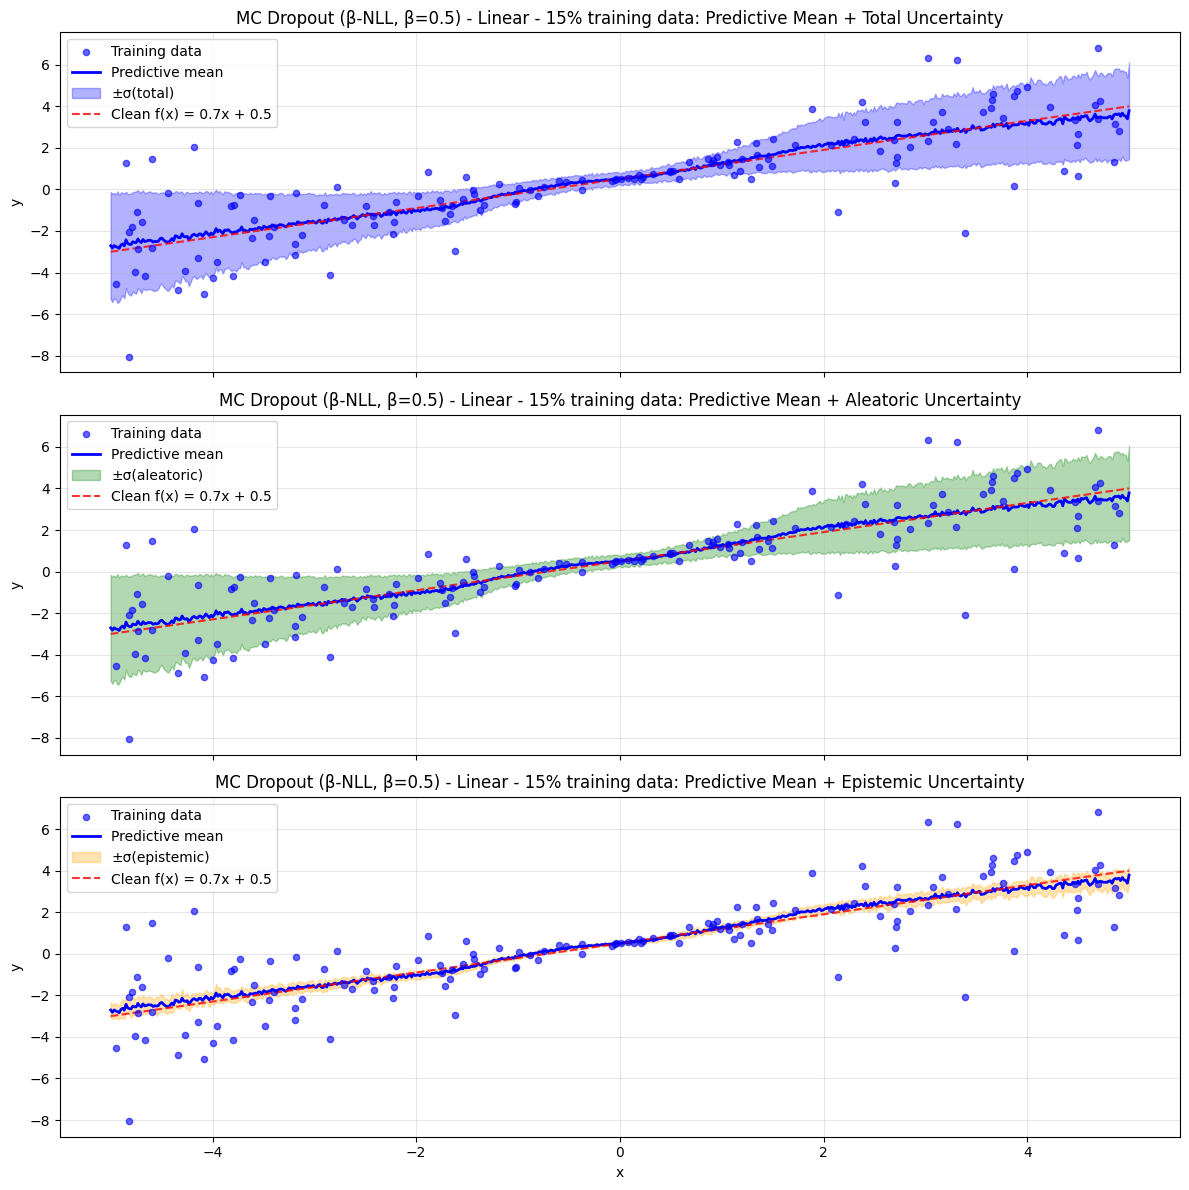


Training with 25% of training data (250 samples)
[beta_nll] Epoch 100/700 - avg loss 1.0646
[beta_nll] Epoch 200/700 - avg loss 1.0988
[beta_nll] Epoch 300/700 - avg loss 1.0618
[beta_nll] Epoch 400/700 - avg loss 1.0960
[beta_nll] Epoch 500/700 - avg loss 0.9736
[beta_nll] Epoch 600/700 - avg loss 1.0446
[beta_nll] Epoch 700/700 - avg loss 1.0865
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_25%_training_data.png


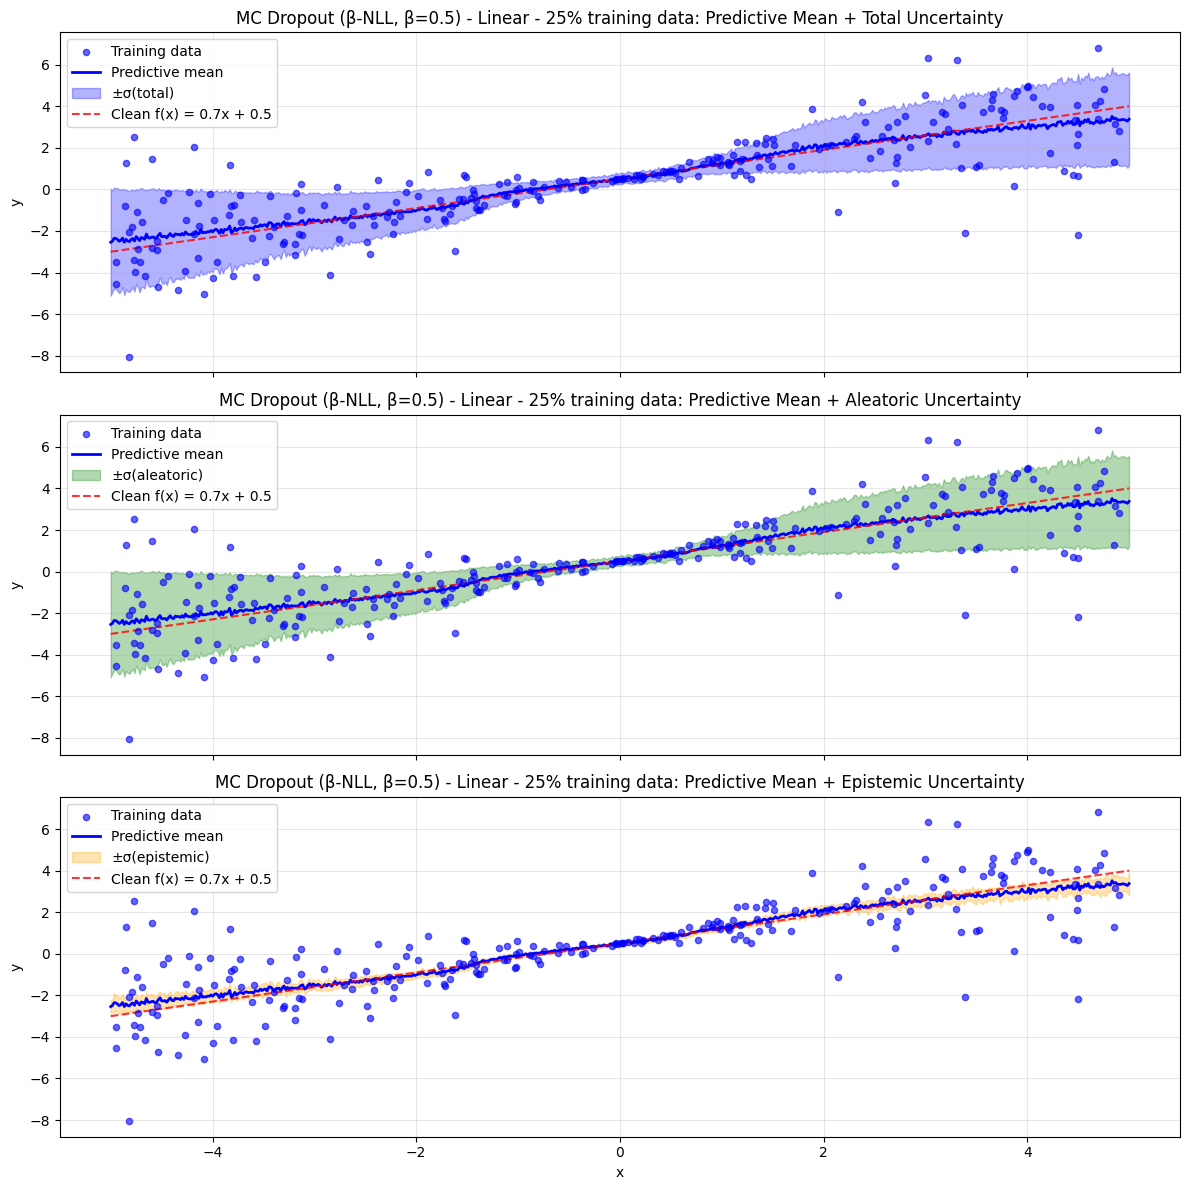


Training with 50% of training data (500 samples)
[beta_nll] Epoch 100/700 - avg loss 1.2492
[beta_nll] Epoch 200/700 - avg loss 1.2124
[beta_nll] Epoch 300/700 - avg loss 1.2267
[beta_nll] Epoch 400/700 - avg loss 1.2400
[beta_nll] Epoch 500/700 - avg loss 1.2279
[beta_nll] Epoch 600/700 - avg loss 1.2674
[beta_nll] Epoch 700/700 - avg loss 1.2563
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_50%_training_data.png


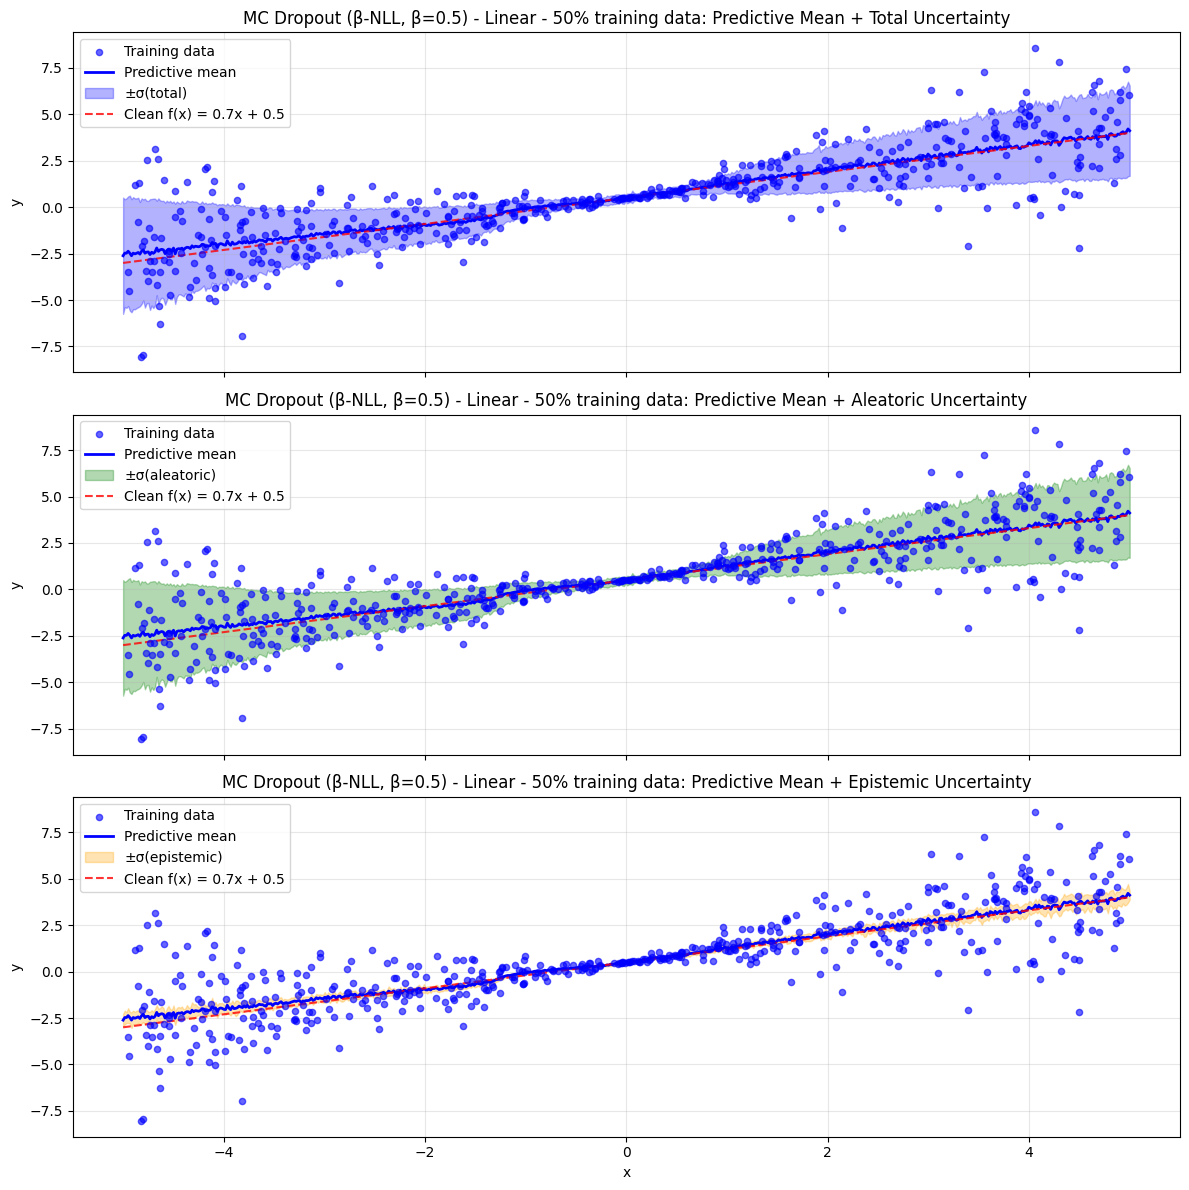


Training with 100% of training data (1000 samples)
[beta_nll] Epoch 100/700 - avg loss 1.1771
[beta_nll] Epoch 200/700 - avg loss 1.1763
[beta_nll] Epoch 300/700 - avg loss 1.1468
[beta_nll] Epoch 400/700 - avg loss 1.1639
[beta_nll] Epoch 500/700 - avg loss 1.1712
[beta_nll] Epoch 600/700 - avg loss 1.1625
[beta_nll] Epoch 700/700 - avg loss 1.1873
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_100%_training_data.png


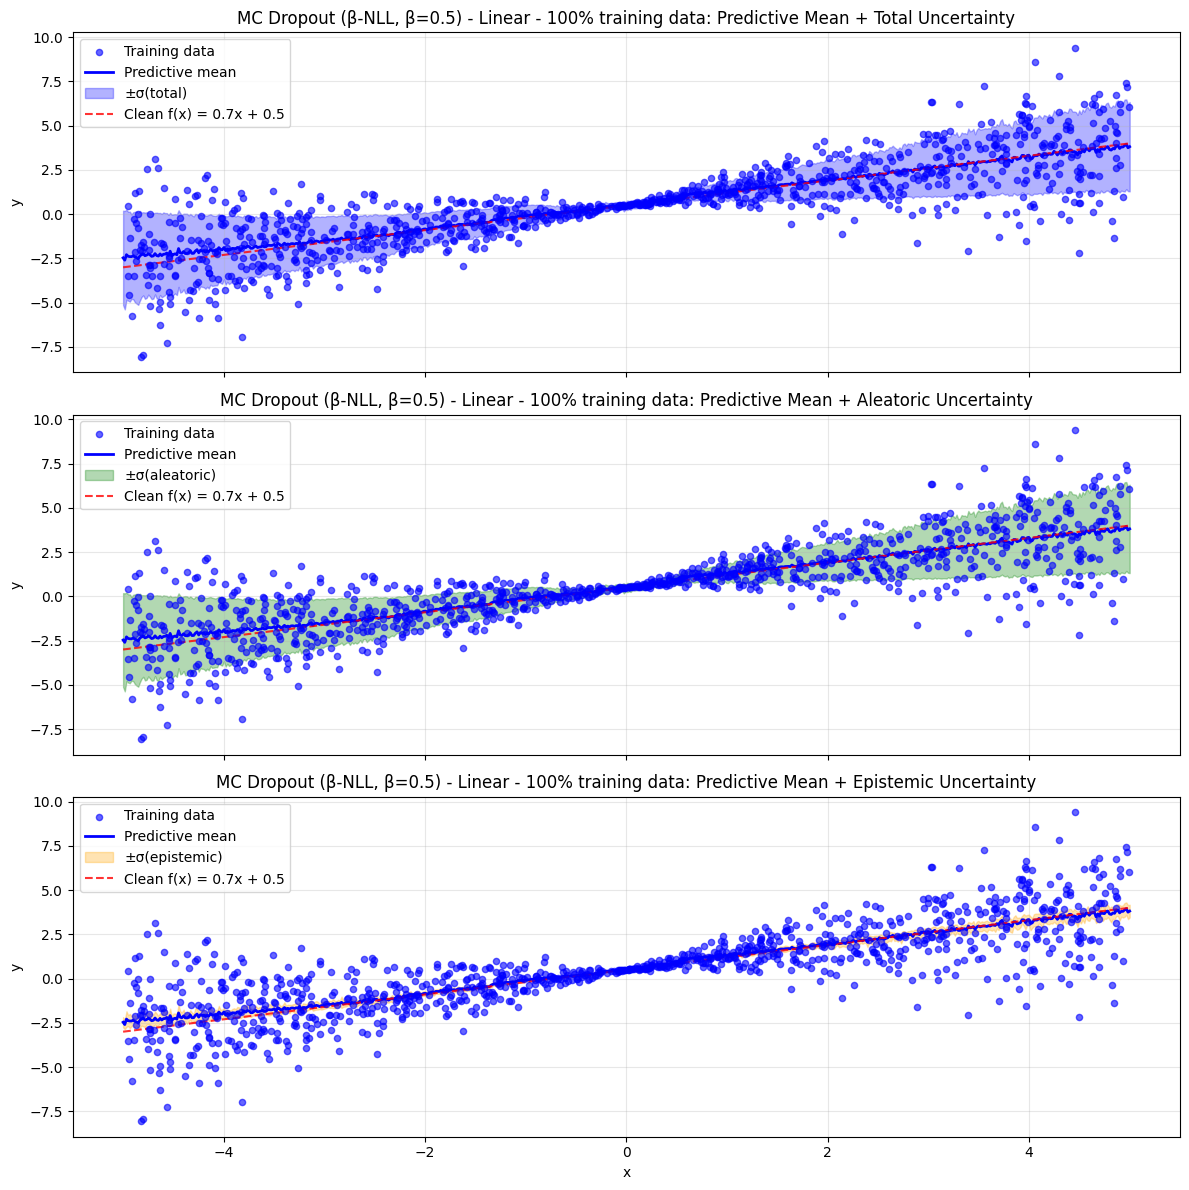


Normalized Average Uncertainties by Percentage - Linear Function

Percentage   Avg Aleatoric (norm)      Avg Epistemic (norm)      Avg Total (norm)          Correlation (Epi-Ale)    
------------------------------------------------------------------------------------------------------------------------
  1%                        0.131364                  0.128046                  0.259410                  0.173767
  5%                        0.276363                  0.055218                  0.331581                  0.849571
 10%                        0.224724                  0.046752                  0.271476                  0.863357
 15%                        0.191686                  0.036927                  0.228613                  0.836562
 25%                        0.191902                  0.031676                  0.223578                  0.854353
 50%                        0.220575                  0.032341                  0.252915                  0.797456
100% 

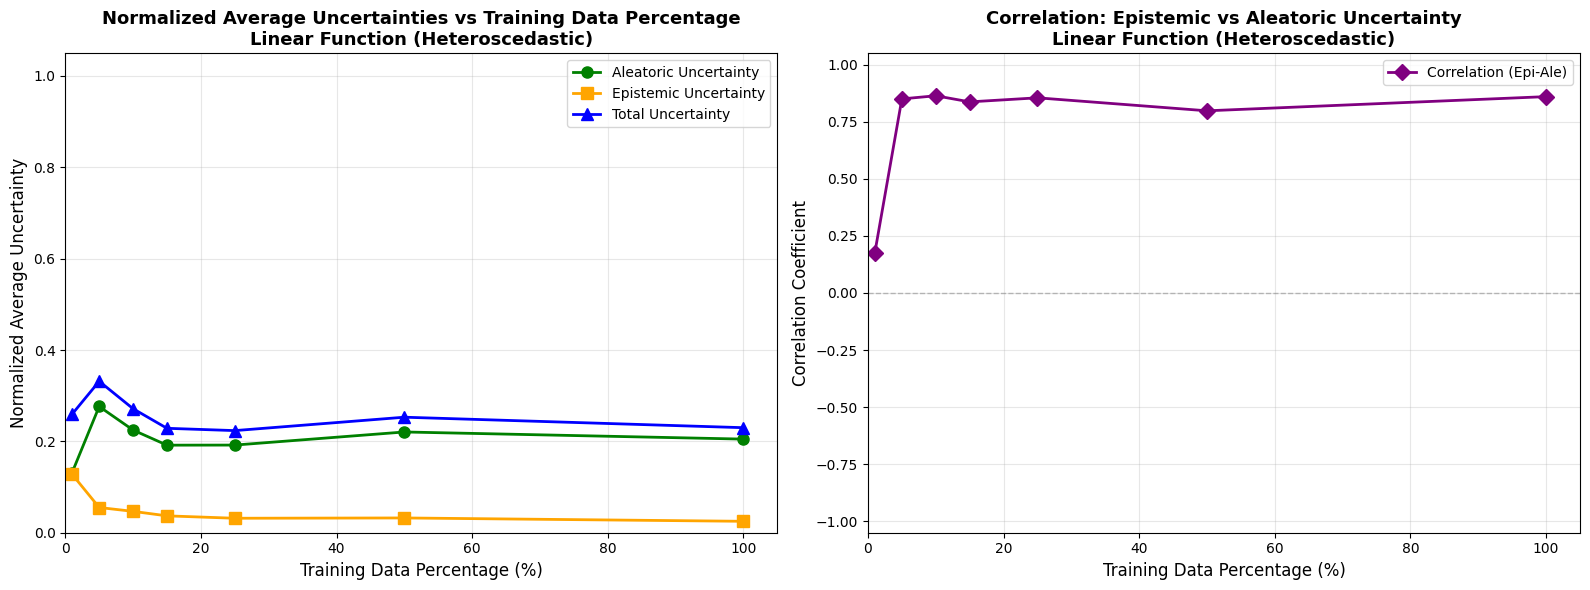


################################################################################
# Function Type: Sinusoidal (sin)
################################################################################


Training with 1% of training data (10 samples)
[beta_nll] Epoch 100/700 - avg loss 4.5379
[beta_nll] Epoch 200/700 - avg loss 4.2698
[beta_nll] Epoch 300/700 - avg loss 3.6736
[beta_nll] Epoch 400/700 - avg loss 2.9855
[beta_nll] Epoch 500/700 - avg loss 2.9275
[beta_nll] Epoch 600/700 - avg loss 2.4635
[beta_nll] Epoch 700/700 - avg loss 2.0756
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Sinusoidal_-_1%_training_data.png


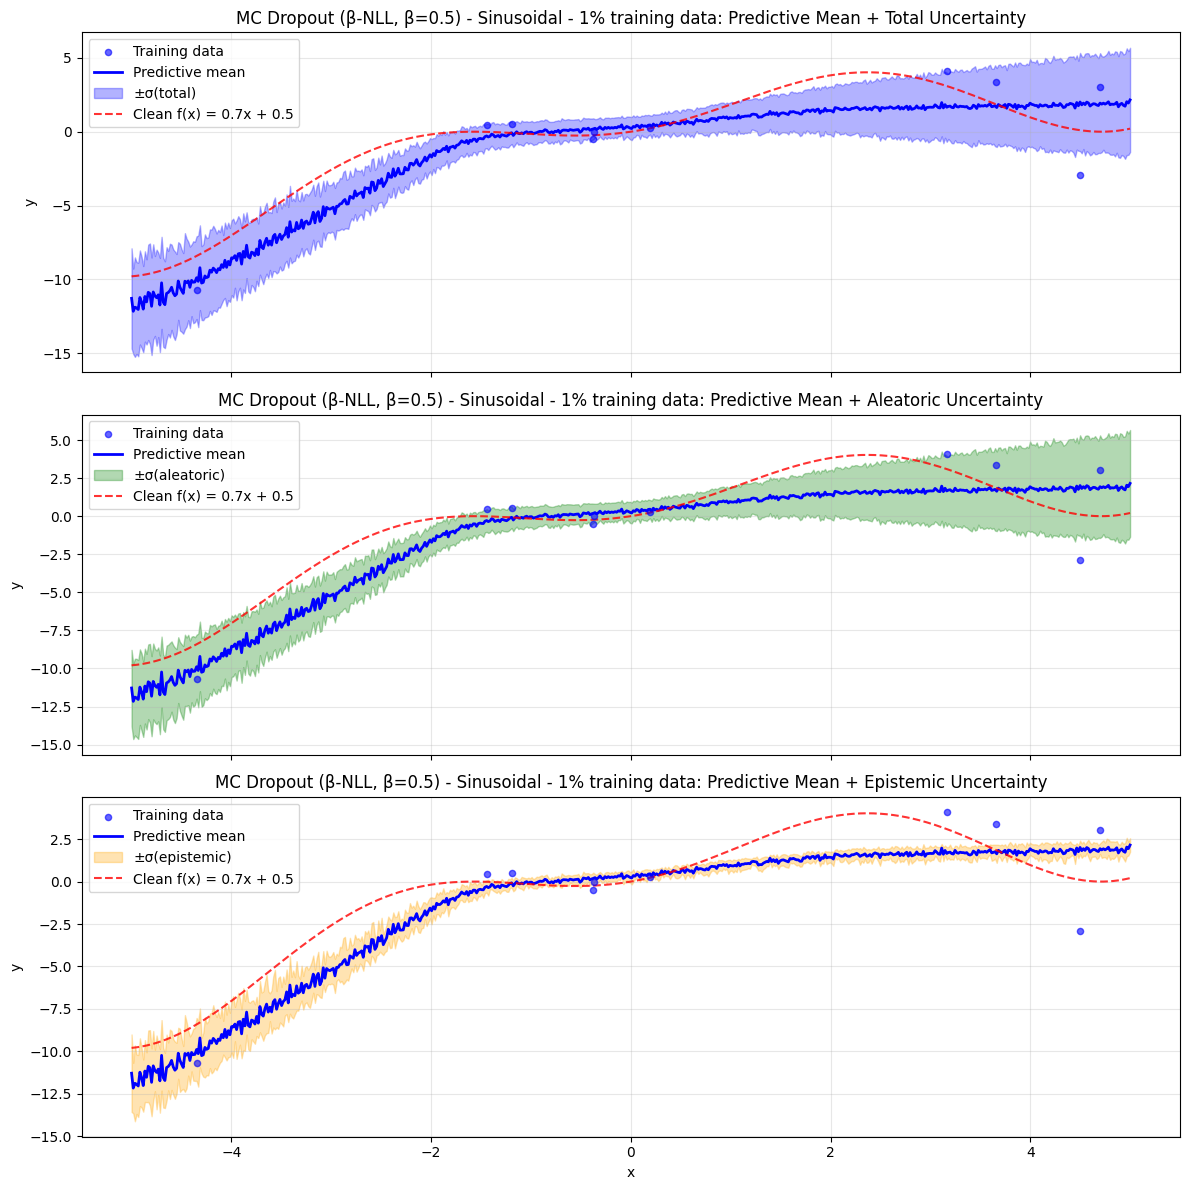


Training with 5% of training data (50 samples)
[beta_nll] Epoch 100/700 - avg loss 4.7688
[beta_nll] Epoch 200/700 - avg loss 3.4131
[beta_nll] Epoch 300/700 - avg loss 2.4397
[beta_nll] Epoch 400/700 - avg loss 2.5015
[beta_nll] Epoch 500/700 - avg loss 2.2520
[beta_nll] Epoch 600/700 - avg loss 2.4274
[beta_nll] Epoch 700/700 - avg loss 2.1923
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Sinusoidal_-_5%_training_data.png


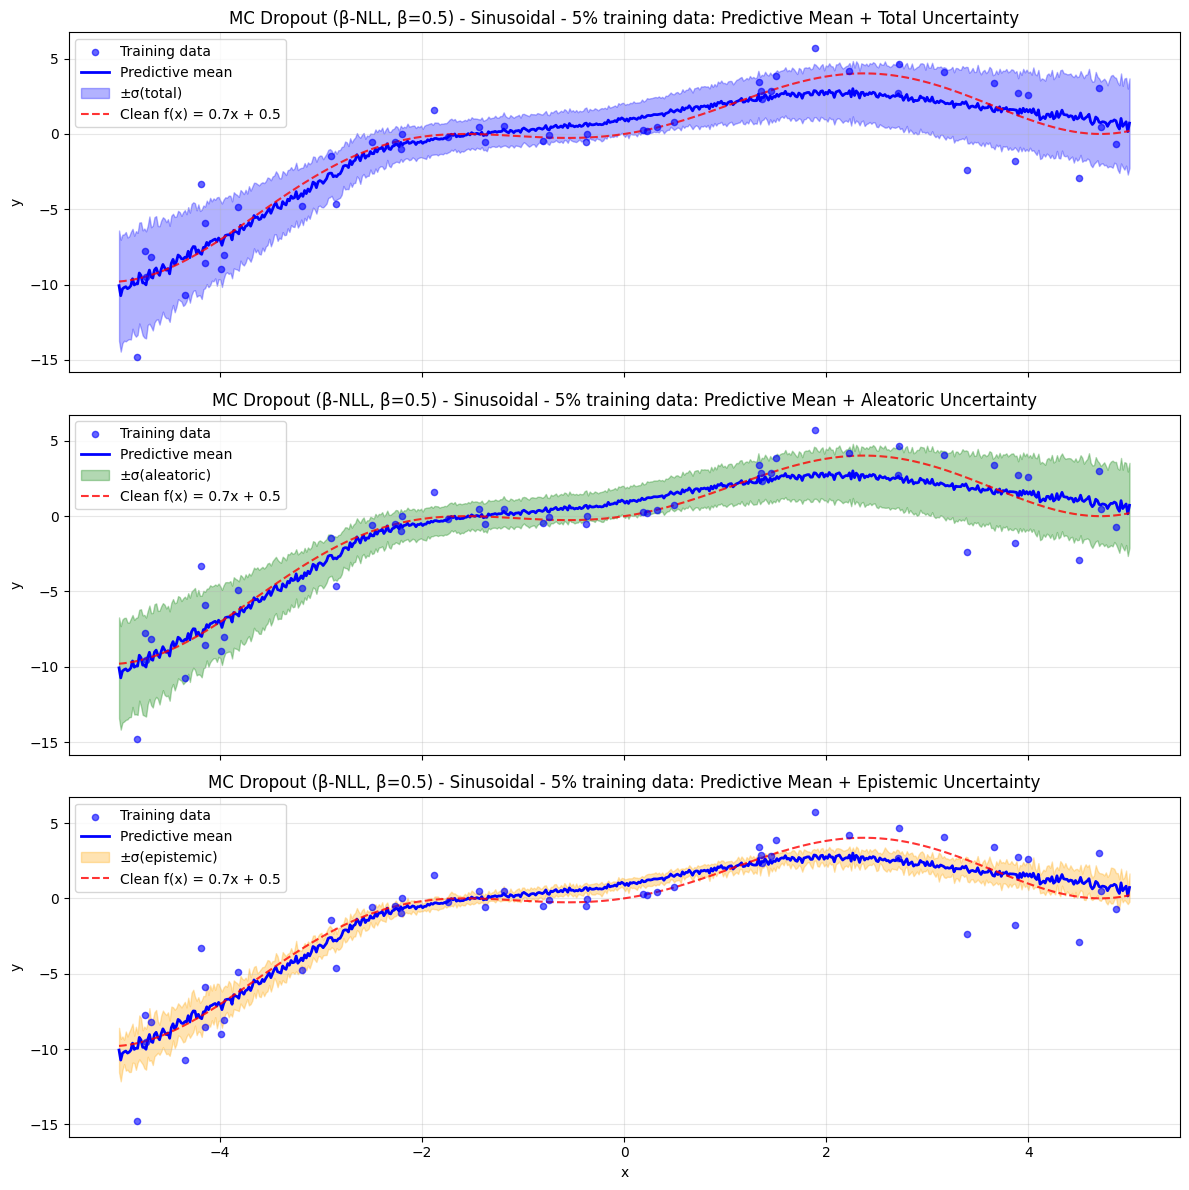


Training with 10% of training data (100 samples)
[beta_nll] Epoch 100/700 - avg loss 2.9031
[beta_nll] Epoch 200/700 - avg loss 2.0727
[beta_nll] Epoch 300/700 - avg loss 1.7188
[beta_nll] Epoch 400/700 - avg loss 1.7294
[beta_nll] Epoch 500/700 - avg loss 1.5940
[beta_nll] Epoch 600/700 - avg loss 1.3252
[beta_nll] Epoch 700/700 - avg loss 1.5498
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Sinusoidal_-_10%_training_data.png


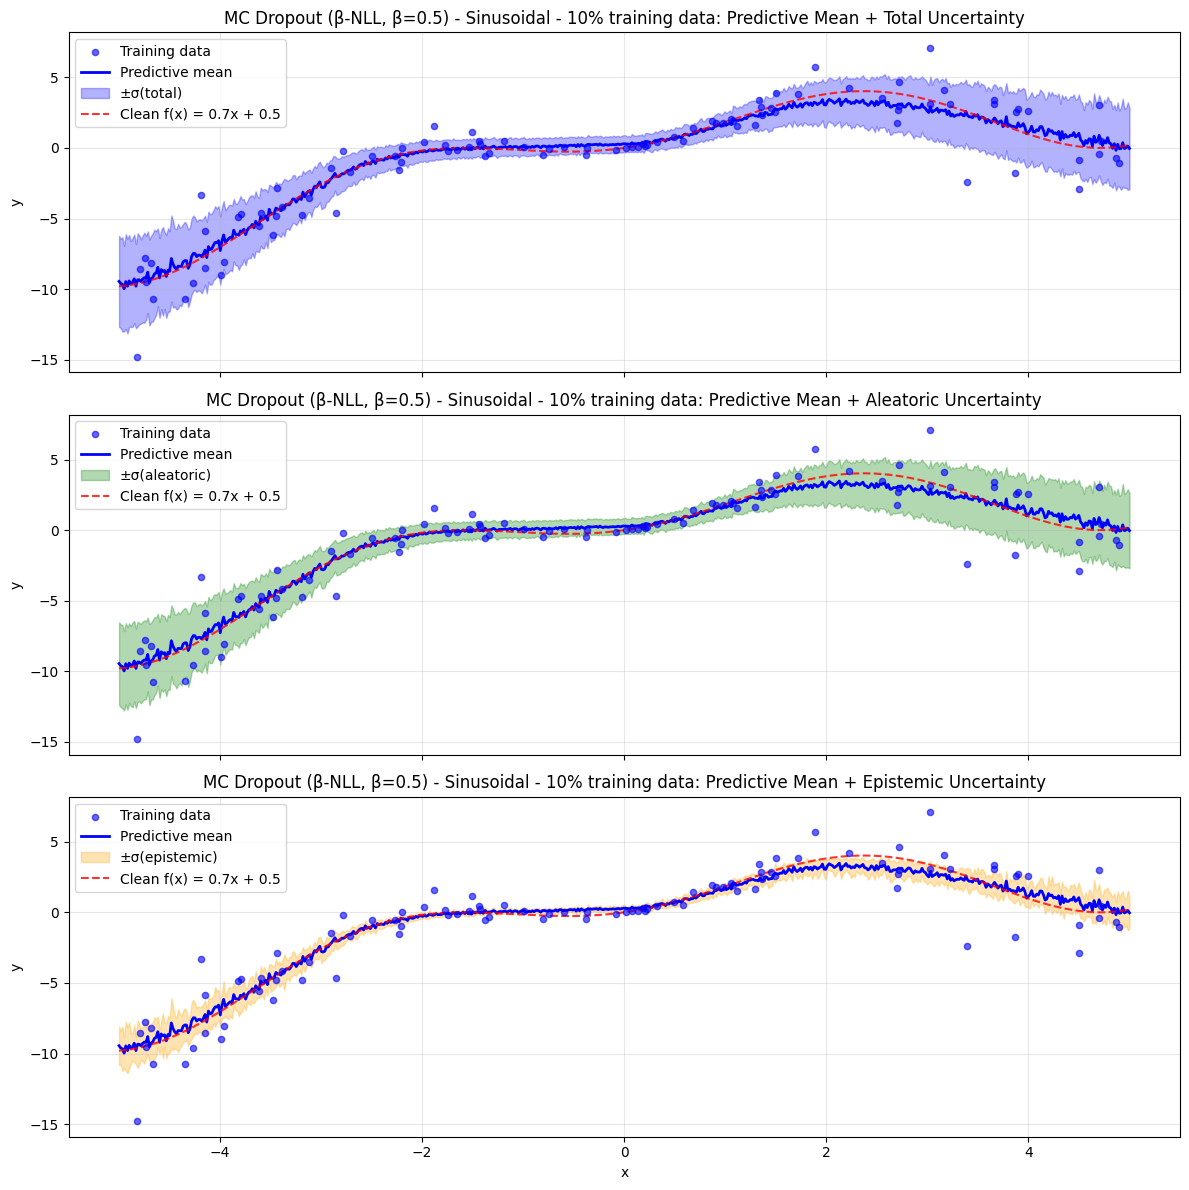


Training with 15% of training data (150 samples)
[beta_nll] Epoch 100/700 - avg loss 2.3548
[beta_nll] Epoch 200/700 - avg loss 1.9308
[beta_nll] Epoch 300/700 - avg loss 1.6210
[beta_nll] Epoch 400/700 - avg loss 1.4135
[beta_nll] Epoch 500/700 - avg loss 1.4922
[beta_nll] Epoch 600/700 - avg loss 1.4150
[beta_nll] Epoch 700/700 - avg loss 1.3597
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Sinusoidal_-_15%_training_data.png


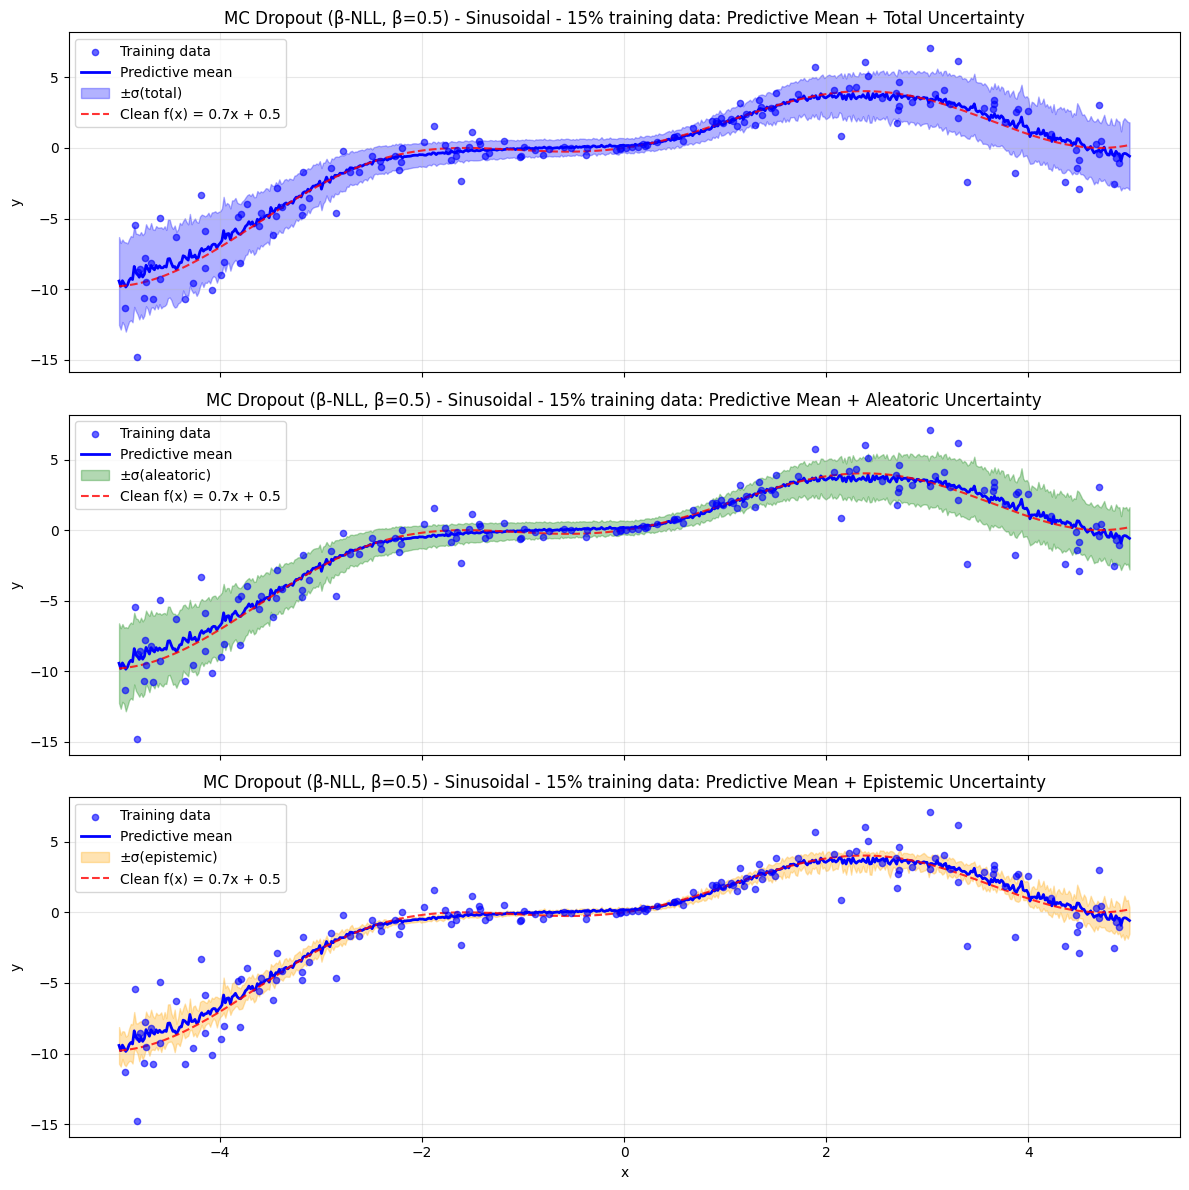


Training with 25% of training data (250 samples)
[beta_nll] Epoch 100/700 - avg loss 1.7605
[beta_nll] Epoch 200/700 - avg loss 1.5800
[beta_nll] Epoch 300/700 - avg loss 1.3463
[beta_nll] Epoch 400/700 - avg loss 1.3712
[beta_nll] Epoch 500/700 - avg loss 1.1705
[beta_nll] Epoch 600/700 - avg loss 1.2197
[beta_nll] Epoch 700/700 - avg loss 1.2964
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Sinusoidal_-_25%_training_data.png


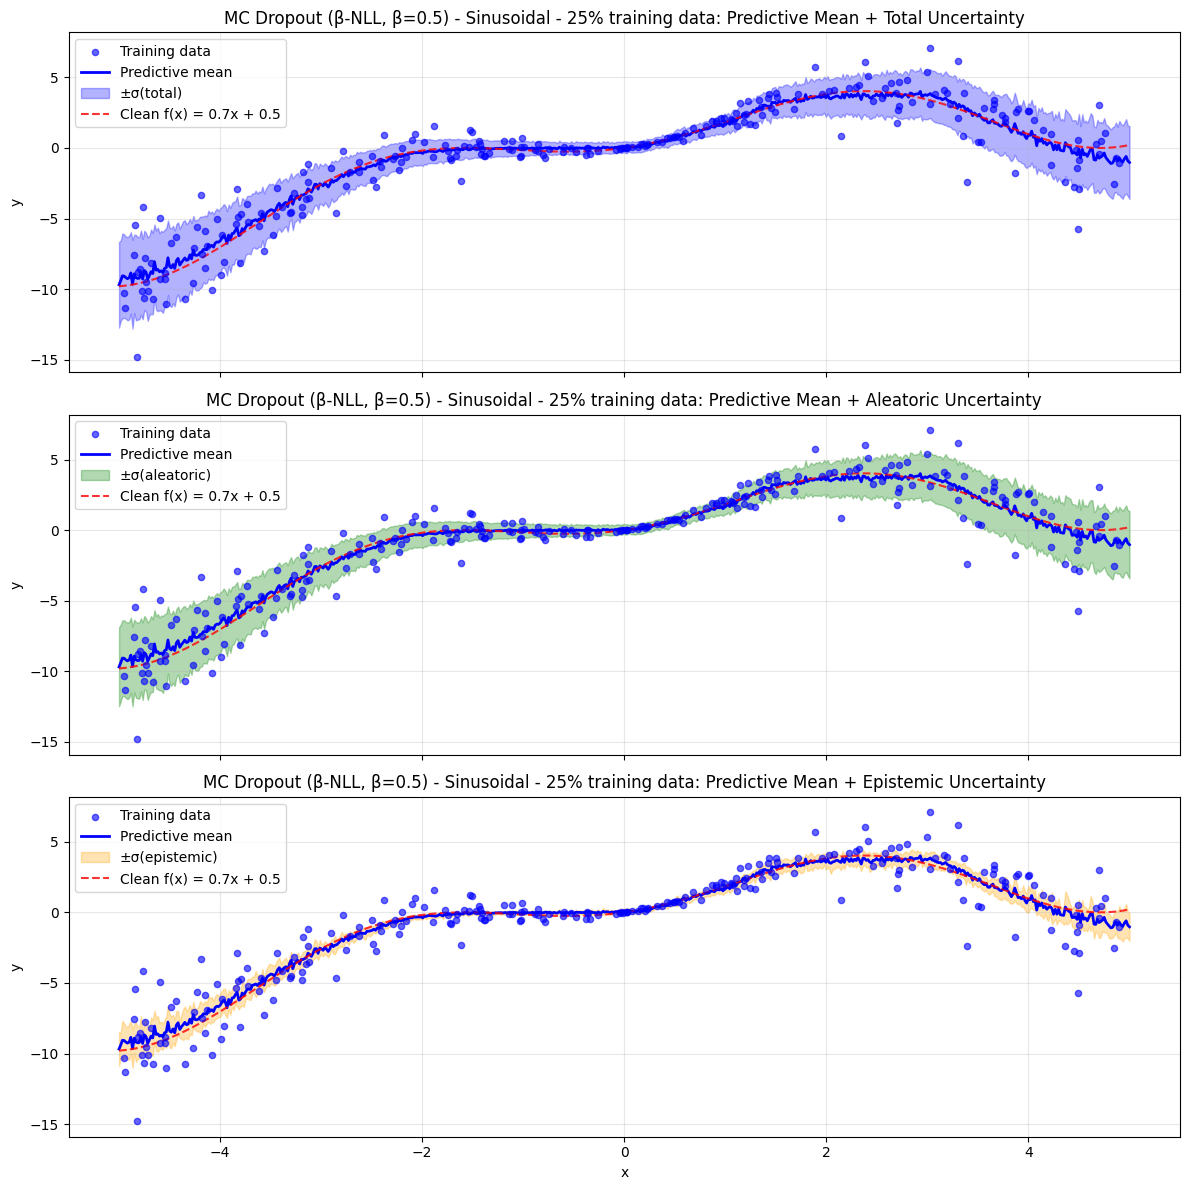


Training with 50% of training data (500 samples)
[beta_nll] Epoch 100/700 - avg loss 1.6501
[beta_nll] Epoch 200/700 - avg loss 1.4000
[beta_nll] Epoch 300/700 - avg loss 1.4050
[beta_nll] Epoch 400/700 - avg loss 1.3981
[beta_nll] Epoch 500/700 - avg loss 1.3529
[beta_nll] Epoch 600/700 - avg loss 1.4204
[beta_nll] Epoch 700/700 - avg loss 1.3506
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Sinusoidal_-_50%_training_data.png


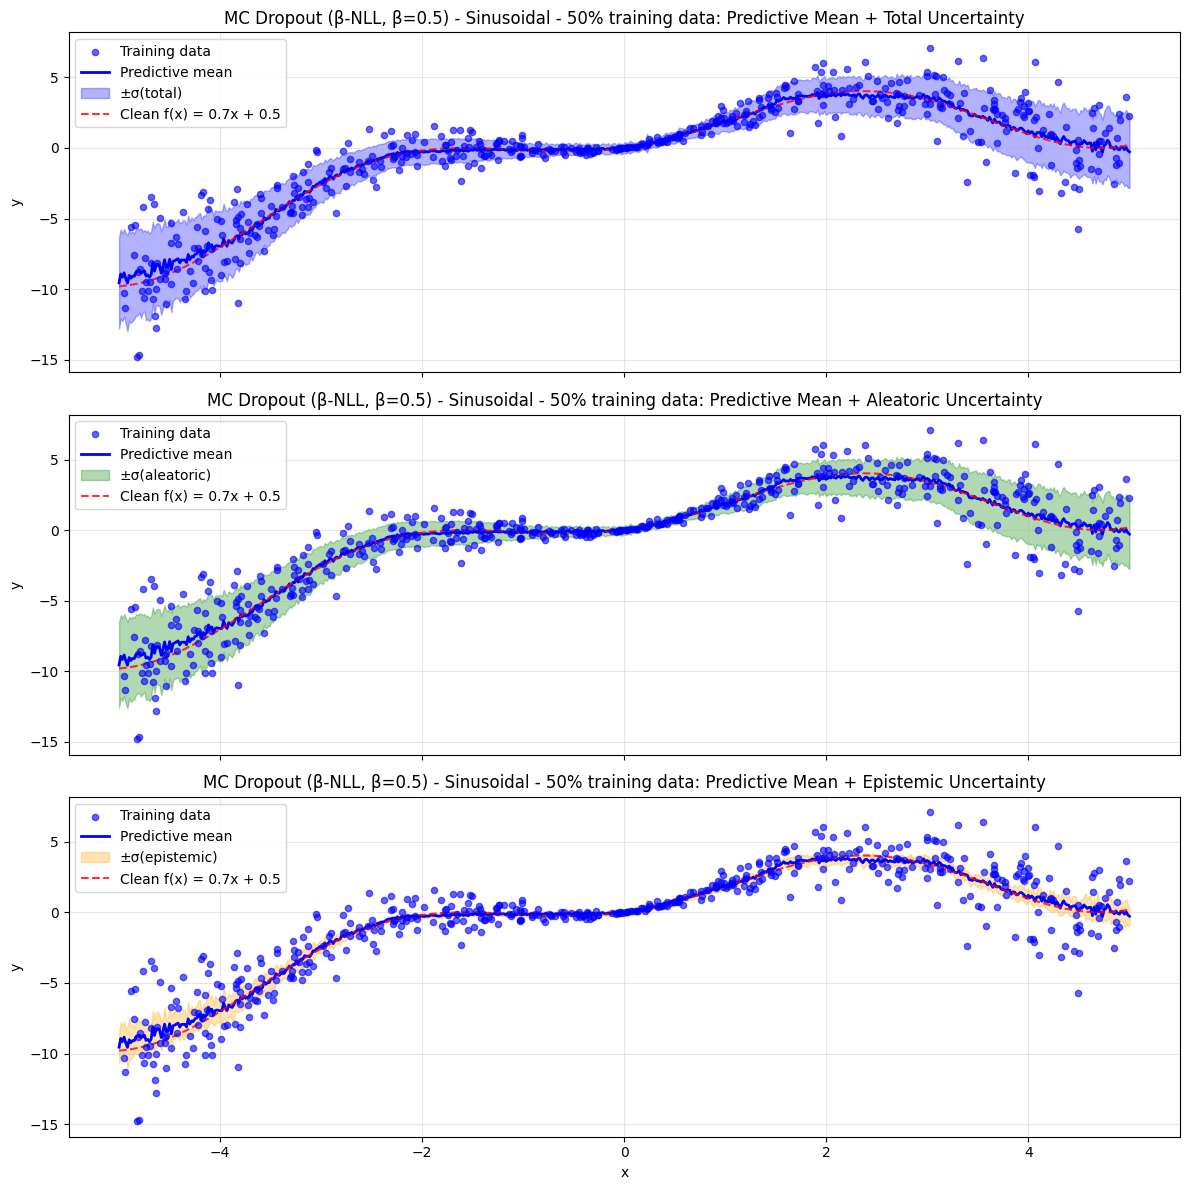


Training with 100% of training data (1000 samples)
[beta_nll] Epoch 100/700 - avg loss 1.4074
[beta_nll] Epoch 200/700 - avg loss 1.3331
[beta_nll] Epoch 300/700 - avg loss 1.2476
[beta_nll] Epoch 400/700 - avg loss 1.2789
[beta_nll] Epoch 500/700 - avg loss 1.2740
[beta_nll] Epoch 600/700 - avg loss 1.2739
[beta_nll] Epoch 700/700 - avg loss 1.3037
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Sinusoidal_-_100%_training_data.png


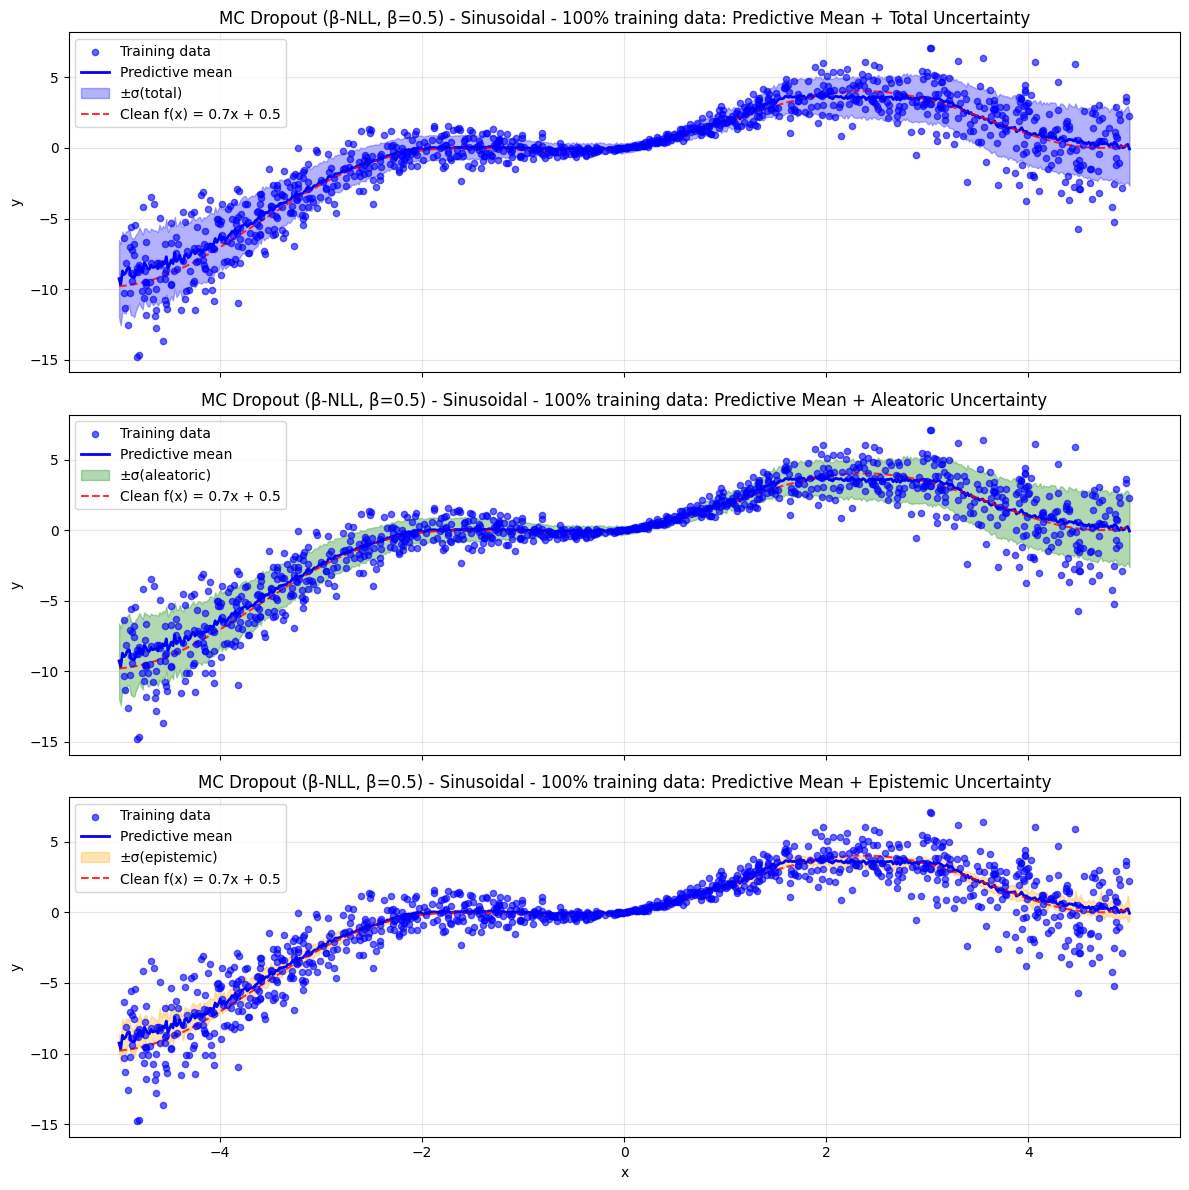


Normalized Average Uncertainties by Percentage - Sinusoidal Function

Percentage   Avg Aleatoric (norm)      Avg Epistemic (norm)      Avg Total (norm)          Correlation (Epi-Ale)    
------------------------------------------------------------------------------------------------------------------------
  1%                        0.256459                  0.117446                  0.373905                  0.188314
  5%                        0.270313                  0.090445                  0.360758                  0.800696
 10%                        0.208147                  0.087564                  0.295711                  0.827989
 15%                        0.170474                  0.071989                  0.242463                  0.836409
 25%                        0.171001                  0.059872                  0.230873                  0.867730
 50%                        0.178207                  0.048675                  0.226882                  0.853118
1

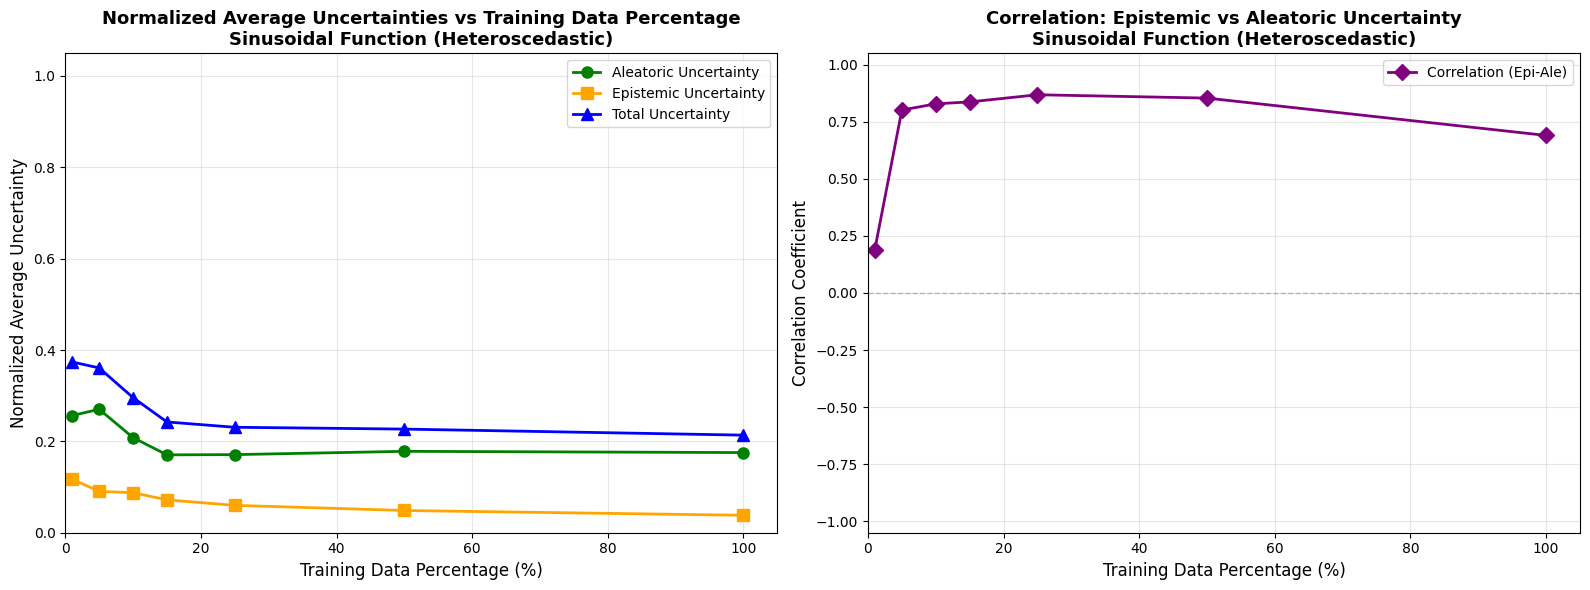

In [ ]:
# Loop through different function types: linear, non-linear, sin
function_types = ["linear", "sin"]
function_names = {"linear": "Linear", "sin": "Sinusoidal"}

for func_type in function_types:
    print(f"\n{'#'*80}")
    print(f"# Function Type: {function_names[func_type]} ({func_type})")
    print(f"{'#'*80}\n")
    
    # Loop through different training data amounts: 1%, 5%, 10%, 15%, 50%, 100%
    # Generate full training dataset using generate_toy_regression function
    np.random.seed(42)
    torch.manual_seed(42)

    # Generate training dataset
    x_train_full, y_train_full, x_grid, y_grid_clean = generate_toy_regression(
        n_train=1000, 
        train_range=(-5, 5), 
        grid_points=600,
        noise_type='heteroscedastic',
        type=func_type
    )

    # Training data percentages to test
    percentages = [1, 5, 10, 15, 25, 50, 100]
      
    # Main loop: train and evaluate for each percentage
    n_train_full = len(x_train_full)

    # Store uncertainties for each percentage
    uncertainties_by_pct = {pct: {'ale': [], 'epi': [], 'tot': []} for pct in percentages}

    for pct in percentages:
        print(f"\n{'='*60}")
        print(f"Training with {pct}% of training data ({int(n_train_full * pct / 100)} samples)")
        print(f"{'='*60}")
        
        # Set seed for reproducibility of subsampling and training
        np.random.seed(42)
        torch.manual_seed(42)
        
        # Subsample training data
        n_samples = int(n_train_full * pct / 100)
        indices = np.random.choice(n_train_full, size=n_samples, replace=False)
        x_train_subset = x_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # Normalize input x (y stays in original scale)
        x_mean, x_std = normalize_x(x_train_subset)
        x_train_subset_norm = normalize_x_data(x_train_subset, x_mean, x_std)
        x_grid_norm = normalize_x_data(x_grid, x_mean, x_std)
        
        # Create dataloader with normalized x (y stays in original scale)
        ds = TensorDataset(torch.from_numpy(x_train_subset_norm), torch.from_numpy(y_train_subset))
        loader = DataLoader(ds, batch_size=32, shuffle=True)
        
        # Train MC Dropout model with beta-NLL (β=0.5)
        model = MCDropoutRegressor(p=0.1)
        train_model(model, loader, epochs=700, lr=1e-3, loss_type='beta_nll', beta=0.5)
        
        # Make predictions using normalized x_grid (predictions are in original y scale)
        mu_pred, ale_var, epi_var, tot_var = mc_dropout_predict(model, x_grid_norm, M=20)
        
        # Store uncertainties (using variance values)
        uncertainties_by_pct[pct]['ale'].append(ale_var)
        uncertainties_by_pct[pct]['epi'].append(epi_var)
        uncertainties_by_pct[pct]['tot'].append(tot_var)
        
        # Plot uncertainties (original absolute units plot)
        plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_grid_clean, 
                                 mu_pred, ale_var, epi_var, tot_var, 
                                 title=f"MC Dropout (β-NLL, β=0.5) - {function_names[func_type]} - {pct}% training data",
                                 noise_type='heteroscedastic', func_type=func_type)
    

    # Normalize and compute averages for each percentage
    print(f"\n{'='*60}")
    print(f"Normalized Average Uncertainties by Percentage - {function_names[func_type]} Function")
    print(f"{'='*60}")

    # First, collect all values to compute global min/max for normalization
    all_ale = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['ale']) for pct in percentages])
    all_epi = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['epi']) for pct in percentages])
    

    # Compute min and max for normalization
    ale_min, ale_max = all_ale.min(), all_ale.max()
    epi_min, epi_max = all_epi.min(), all_epi.max()
    


    # Normalize function
    def normalize(values, vmin, vmax):
        """Normalize values to [0, 1] range"""
        if vmax - vmin == 0:
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    # Compute and print normalized averages and correlations for each percentage
    print(f"\n{'Percentage':<12} {'Avg Aleatoric (norm)':<25} {'Avg Epistemic (norm)':<25} {'Avg Total (norm)':<25} {'Correlation (Epi-Ale)':<25}")
    print("-" * 120)

    # Store averages and correlations for plotting
    avg_ale_norm_list = []
    avg_epi_norm_list = []
    avg_tot_norm_list = []
    correlation_list = []

    for pct in percentages:
        # Get uncertainties for this percentage
        ale_vals = np.concatenate(uncertainties_by_pct[pct]['ale'])
        epi_vals = np.concatenate(uncertainties_by_pct[pct]['epi'])
        tot_vals = np.concatenate(uncertainties_by_pct[pct]['tot'])
        
        # Normalize
        ale_norm = normalize(ale_vals, ale_min, ale_max)
        epi_norm = normalize(epi_vals, epi_min, epi_max)
        tot_norm = ale_norm + epi_norm
        
        # Compute averages
        avg_ale_norm = np.mean(ale_norm)
        avg_epi_norm = np.mean(epi_norm)
        avg_tot_norm = np.mean(tot_norm)
        
        # Compute correlation between epistemic and aleatoric uncertainties
        # Use original (non-normalized) values for correlation
        correlation = np.corrcoef(epi_vals, ale_vals)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0  # Handle case where std is zero
        
        # Store for plotting
        avg_ale_norm_list.append(avg_ale_norm)
        avg_epi_norm_list.append(avg_epi_norm)
        avg_tot_norm_list.append(avg_tot_norm)
        correlation_list.append(correlation)
        
        print(f"{pct:>3}%        {avg_ale_norm:>24.6f}  {avg_epi_norm:>24.6f}  {avg_tot_norm:>24.6f}  {correlation:>24.6f}")

    print(f"\n{'='*60}")
    print("Note: Average values are normalized to [0, 1] range across all percentages")
    print("      Correlation is computed on original (non-normalized) uncertainty values")
    print(f"{'='*60}")

    # Save summary statistics and create summary plot
    stats_df, fig = save_summary_statistics(
        percentages, avg_ale_norm_list, avg_epi_norm_list, 
        avg_tot_norm_list, correlation_list, 
        function_names[func_type], 
        noise_type='heteroscedastic',
        func_type=func_type
    )
    plt.show()
    plt.close(fig)

## Smaple size Homoscedastic


################################################################################
# Function Type: Linear (linear)
################################################################################


Training with 1% of training data (10 samples)
[beta_nll] Epoch 100/700 - avg loss 26.6504
[beta_nll] Epoch 200/700 - avg loss 6.9471
[beta_nll] Epoch 300/700 - avg loss 5.4694
[beta_nll] Epoch 400/700 - avg loss 3.9118
[beta_nll] Epoch 500/700 - avg loss 6.0679
[beta_nll] Epoch 600/700 - avg loss 6.7644
[beta_nll] Epoch 700/700 - avg loss 8.0202
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_1%_training_data.png


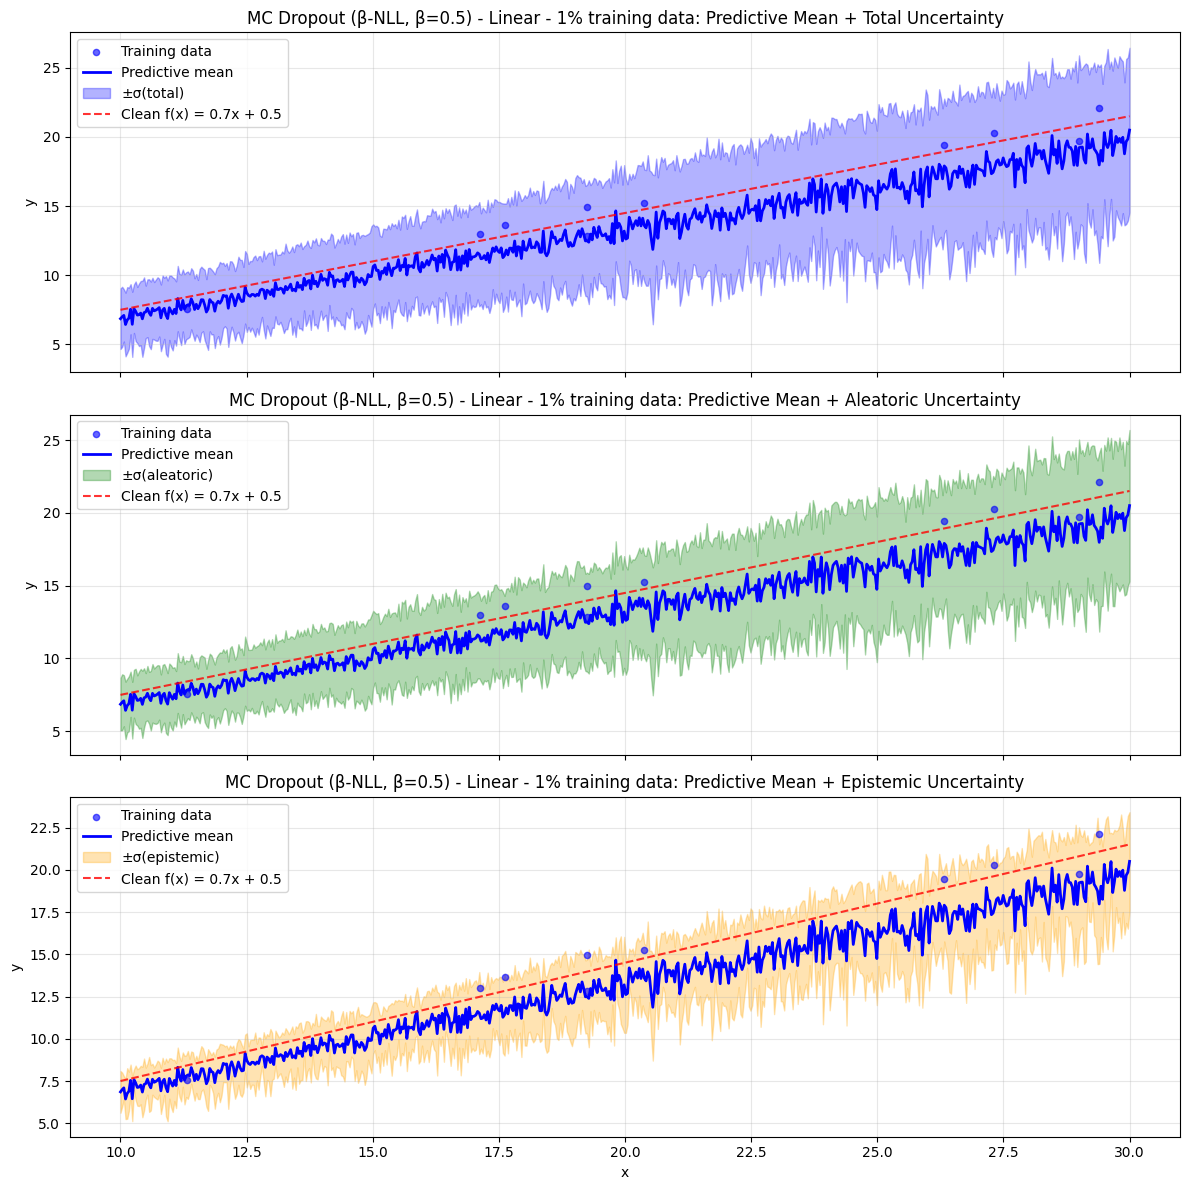


Training with 5% of training data (50 samples)
[beta_nll] Epoch 100/700 - avg loss 5.1079
[beta_nll] Epoch 200/700 - avg loss 5.2412
[beta_nll] Epoch 300/700 - avg loss 3.6329
[beta_nll] Epoch 400/700 - avg loss 3.3136
[beta_nll] Epoch 500/700 - avg loss 2.9940
[beta_nll] Epoch 600/700 - avg loss 2.8445
[beta_nll] Epoch 700/700 - avg loss 2.5271
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_5%_training_data.png


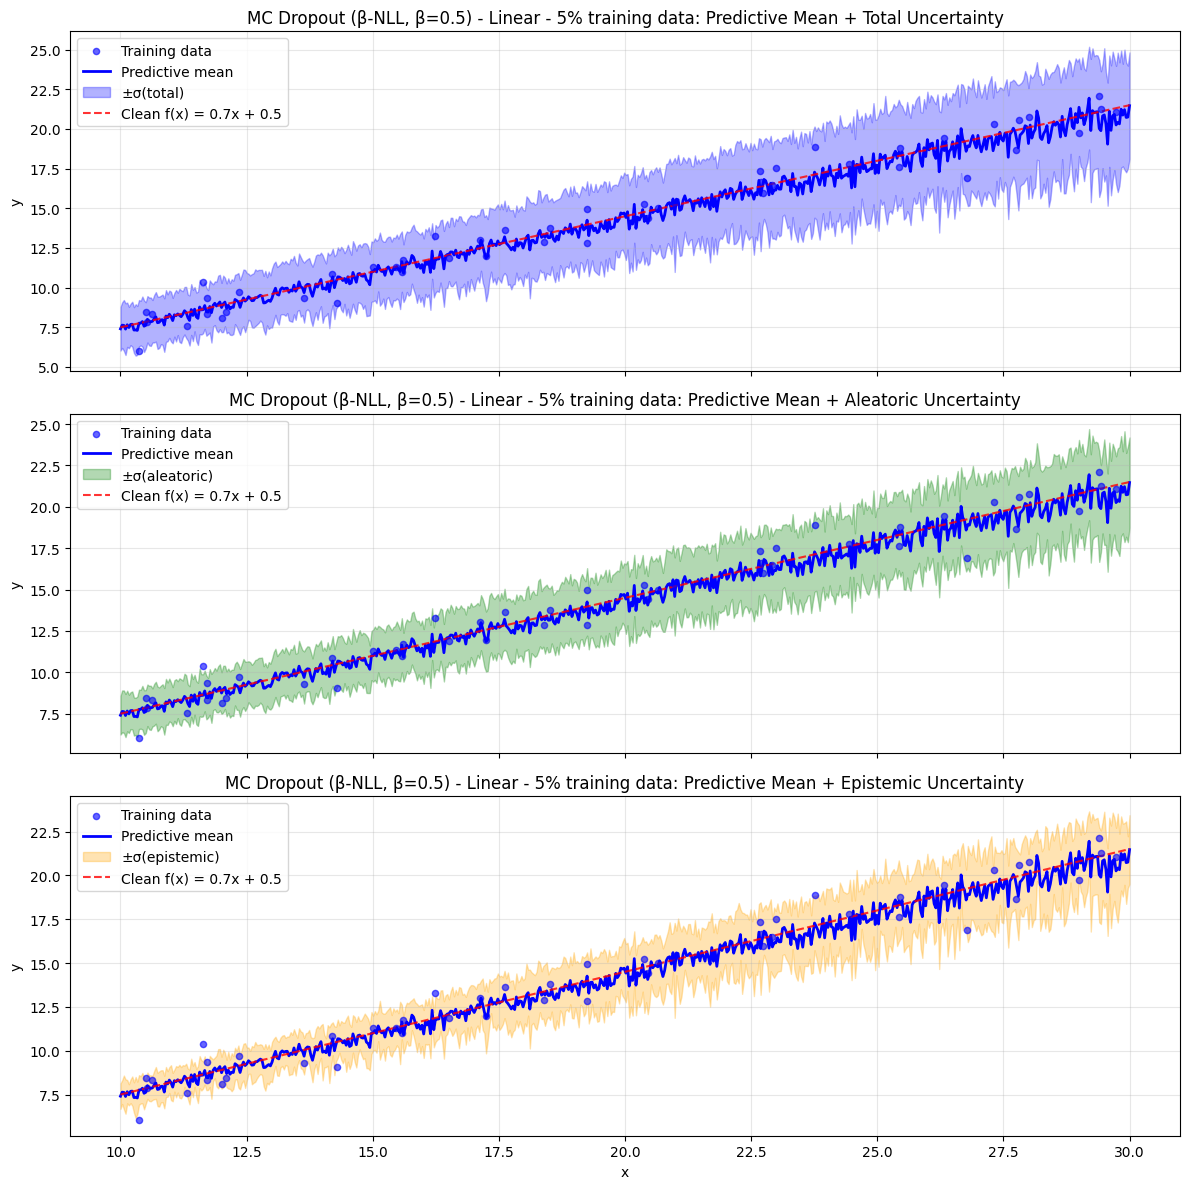


Training with 10% of training data (100 samples)
[beta_nll] Epoch 100/700 - avg loss 5.2536
[beta_nll] Epoch 200/700 - avg loss 3.1697
[beta_nll] Epoch 300/700 - avg loss 2.7661
[beta_nll] Epoch 400/700 - avg loss 2.5673
[beta_nll] Epoch 500/700 - avg loss 1.6333
[beta_nll] Epoch 600/700 - avg loss 2.2131
[beta_nll] Epoch 700/700 - avg loss 1.2695
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_10%_training_data.png


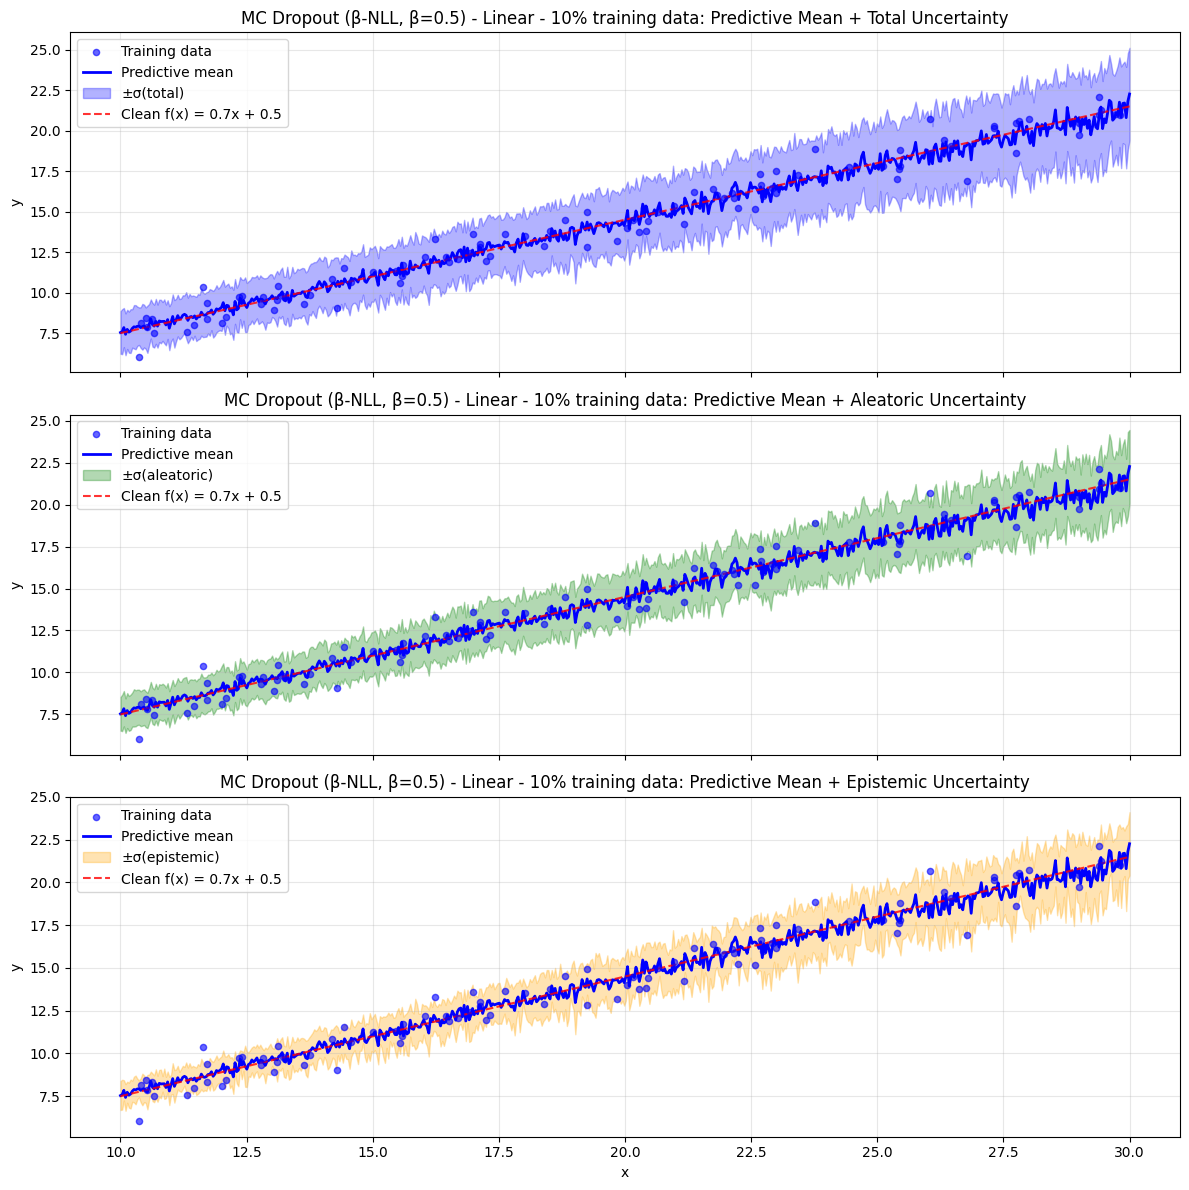


Training with 15% of training data (150 samples)
[beta_nll] Epoch 100/700 - avg loss 4.8332
[beta_nll] Epoch 200/700 - avg loss 2.8450
[beta_nll] Epoch 300/700 - avg loss 1.8164
[beta_nll] Epoch 400/700 - avg loss 1.6976
[beta_nll] Epoch 500/700 - avg loss 1.4510
[beta_nll] Epoch 600/700 - avg loss 1.5353
[beta_nll] Epoch 700/700 - avg loss 1.5169
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_15%_training_data.png


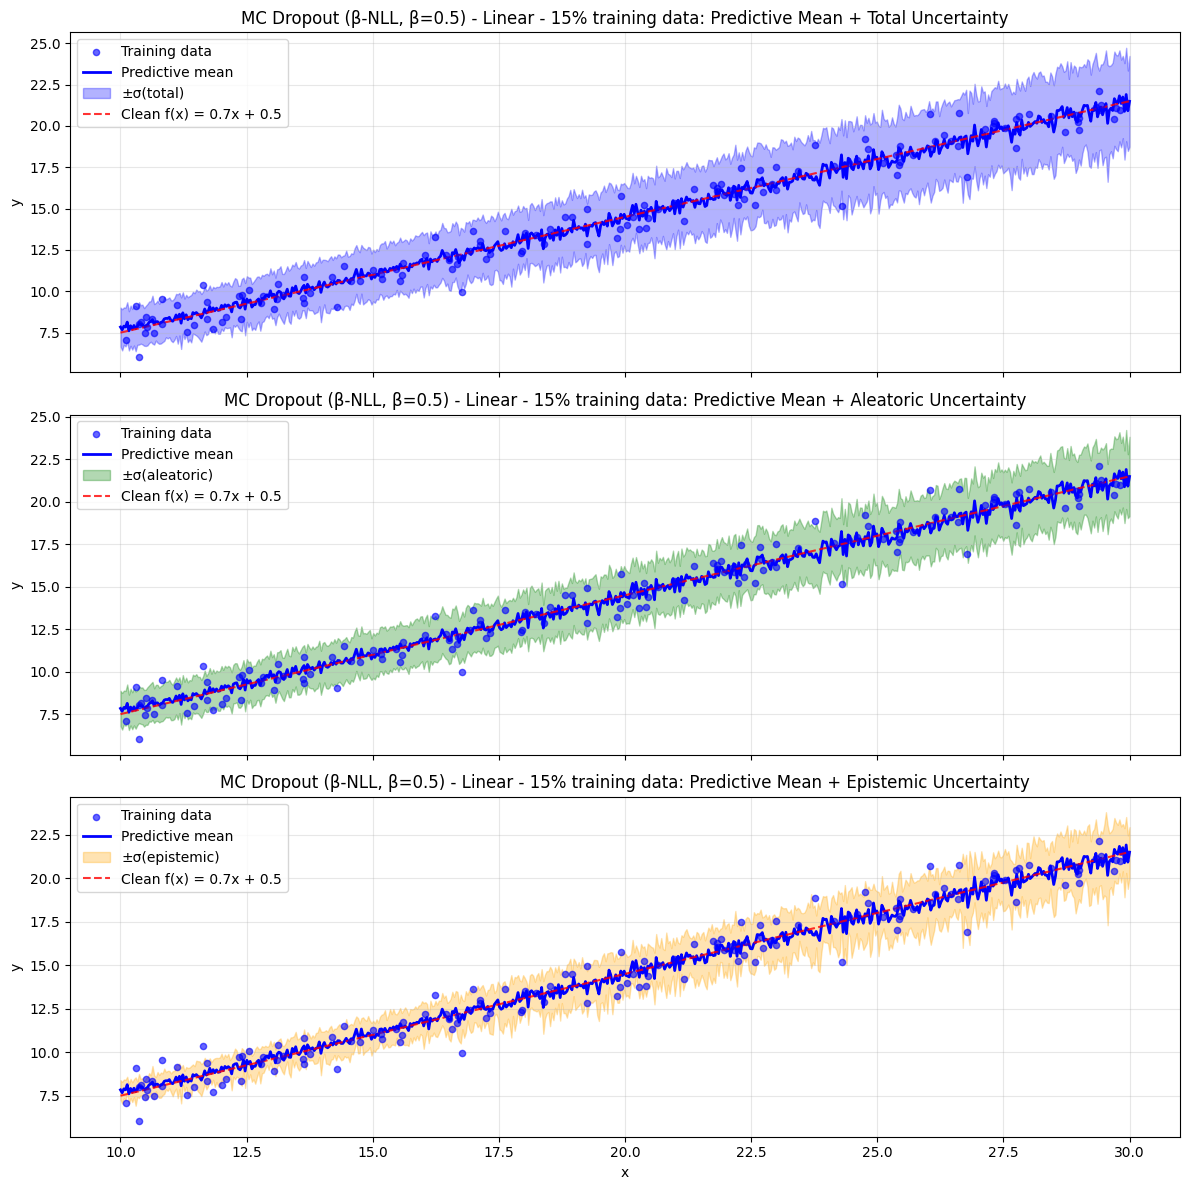


Training with 25% of training data (250 samples)
[beta_nll] Epoch 100/700 - avg loss 3.0958
[beta_nll] Epoch 200/700 - avg loss 1.9873
[beta_nll] Epoch 300/700 - avg loss 1.3369
[beta_nll] Epoch 400/700 - avg loss 1.5479
[beta_nll] Epoch 500/700 - avg loss 1.4107
[beta_nll] Epoch 600/700 - avg loss 1.1379
[beta_nll] Epoch 700/700 - avg loss 1.0734
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_25%_training_data.png


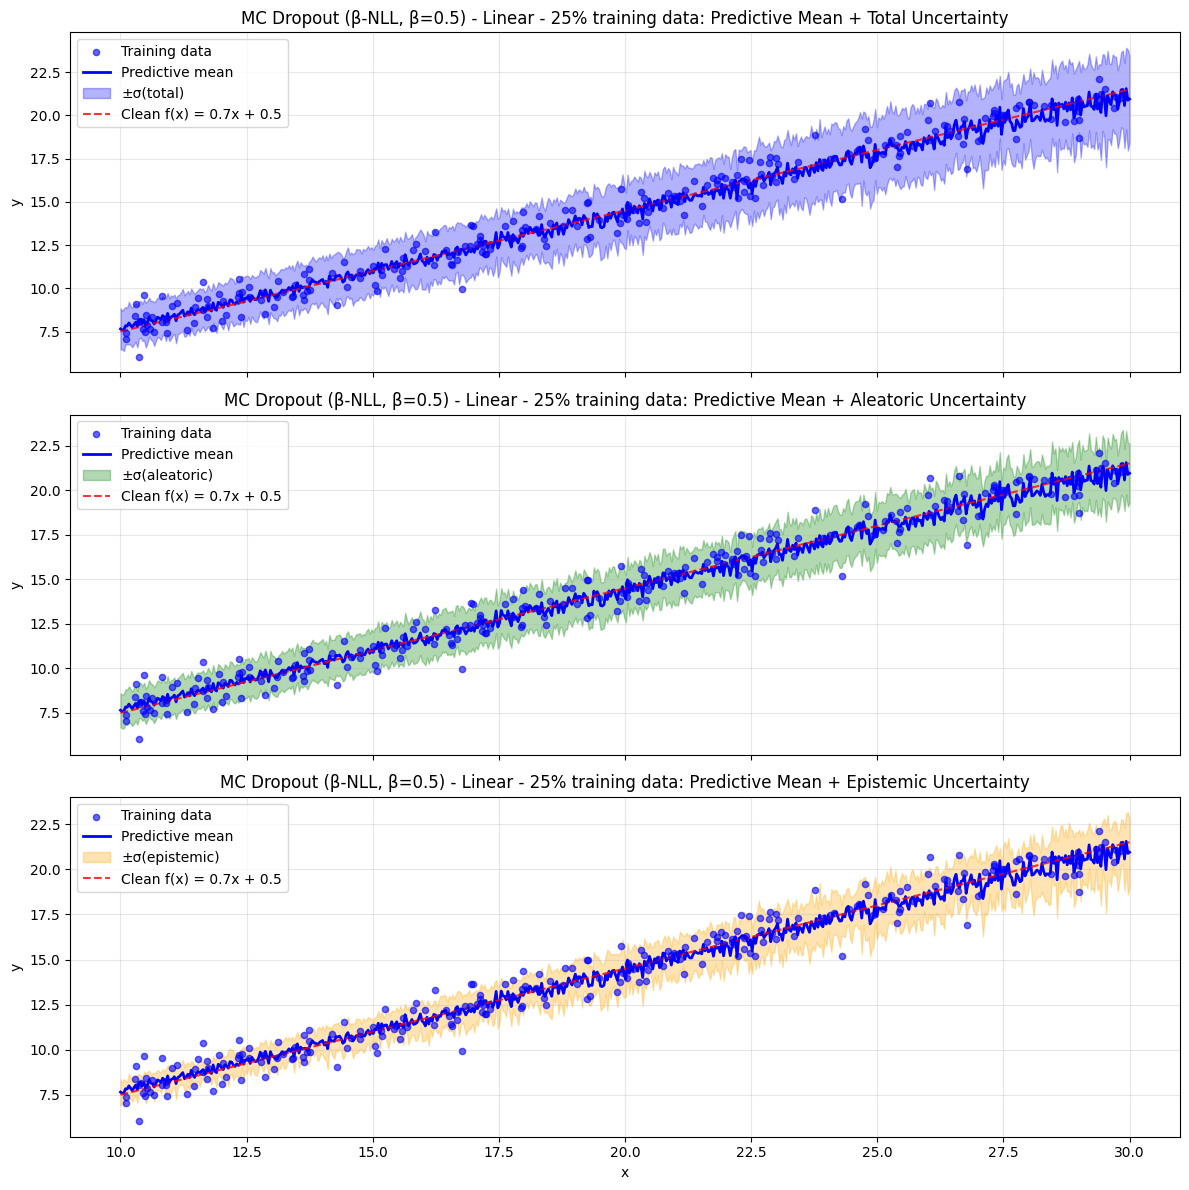


Training with 50% of training data (500 samples)
[beta_nll] Epoch 100/700 - avg loss 2.6266
[beta_nll] Epoch 200/700 - avg loss 1.4763
[beta_nll] Epoch 300/700 - avg loss 1.2256
[beta_nll] Epoch 400/700 - avg loss 1.1643
[beta_nll] Epoch 500/700 - avg loss 1.2335
[beta_nll] Epoch 600/700 - avg loss 1.0495
[beta_nll] Epoch 700/700 - avg loss 0.8690
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_50%_training_data.png


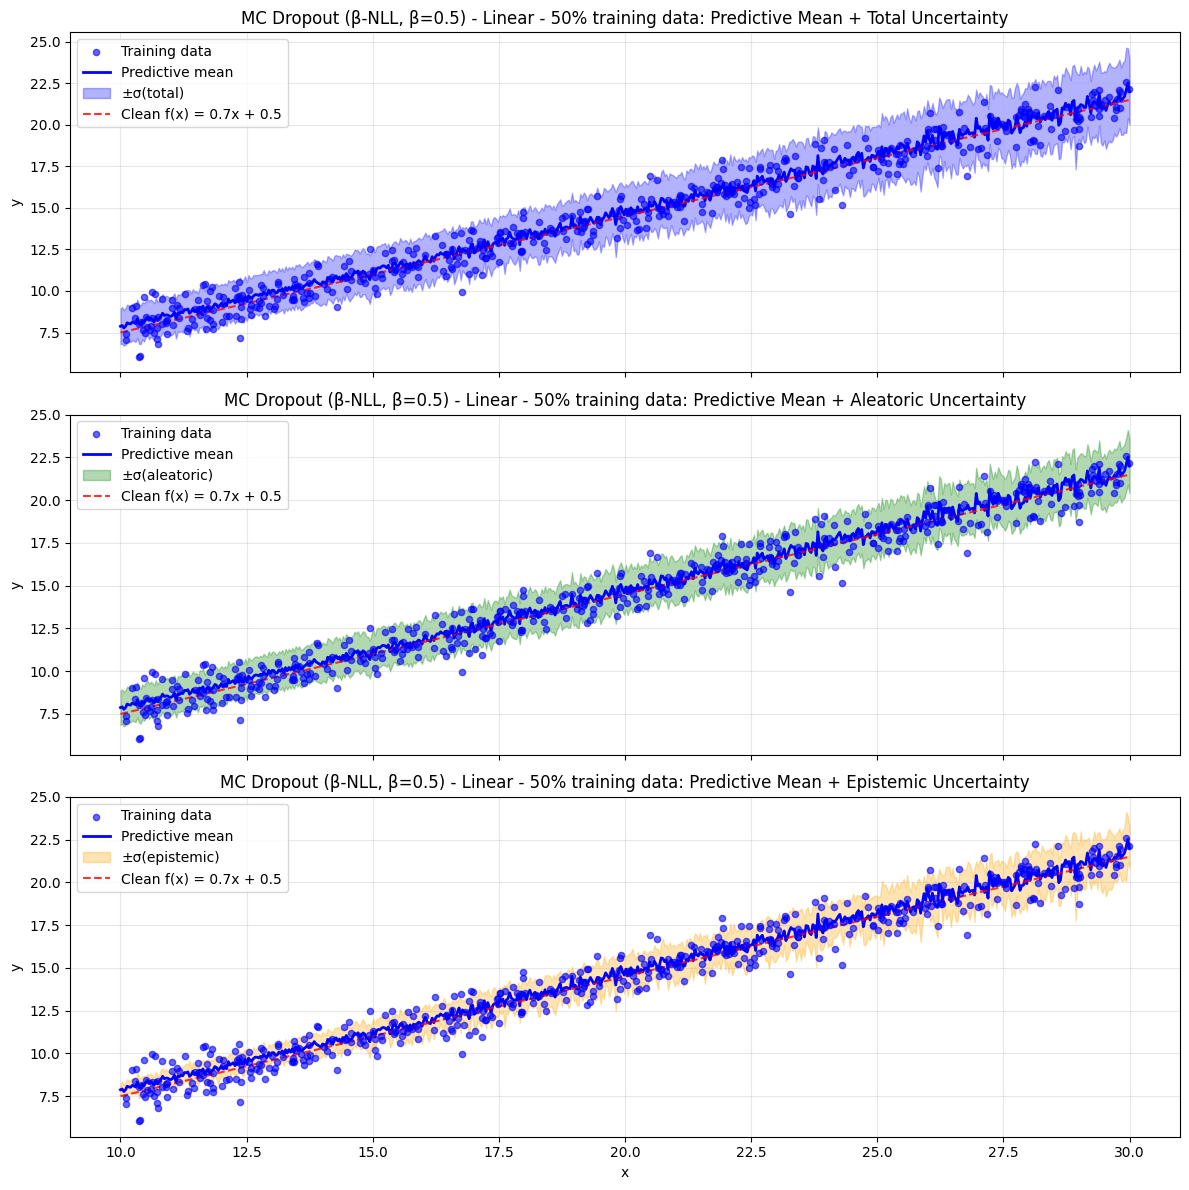


Training with 100% of training data (1000 samples)
[beta_nll] Epoch 100/700 - avg loss 1.7761
[beta_nll] Epoch 200/700 - avg loss 1.4104
[beta_nll] Epoch 300/700 - avg loss 1.1022
[beta_nll] Epoch 400/700 - avg loss 0.8605
[beta_nll] Epoch 500/700 - avg loss 0.8960
[beta_nll] Epoch 600/700 - avg loss 0.7649
[beta_nll] Epoch 700/700 - avg loss 0.8051
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods\results\sample_size\plots\uncertainties\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_100%_training_data.png


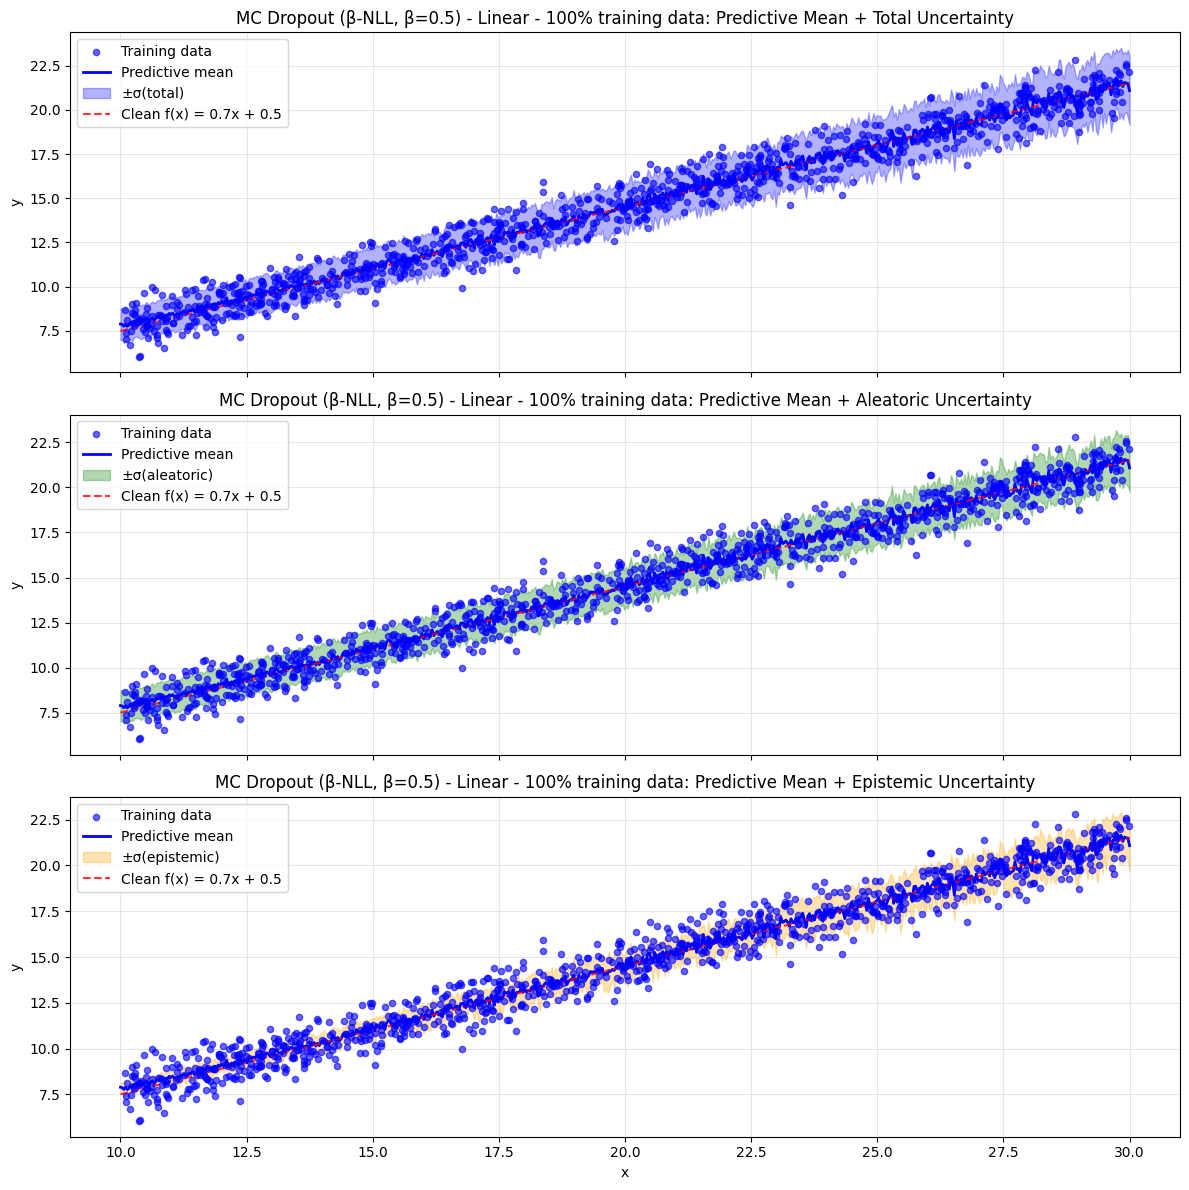


Normalized Average Uncertainties by Percentage - Linear Function

Percentage   Avg Aleatoric (norm)      Avg Epistemic (norm)      Avg Total (norm)          Correlation (Epi-Ale)    
------------------------------------------------------------------------------------------------------------------------
  1%                        0.324586                  0.259383                  0.583968                  0.827762
  5%                        0.090472                  0.141803                  0.232274                  0.789182
 10%                        0.047058                  0.097763                  0.144821                  0.758718
 15%                        0.048266                  0.084277                  0.132543                  0.730695
 25%                        0.028369                  0.065575                  0.093944                  0.743523
 50%                        0.023938                  0.051655                  0.075593                  0.771265
100% 

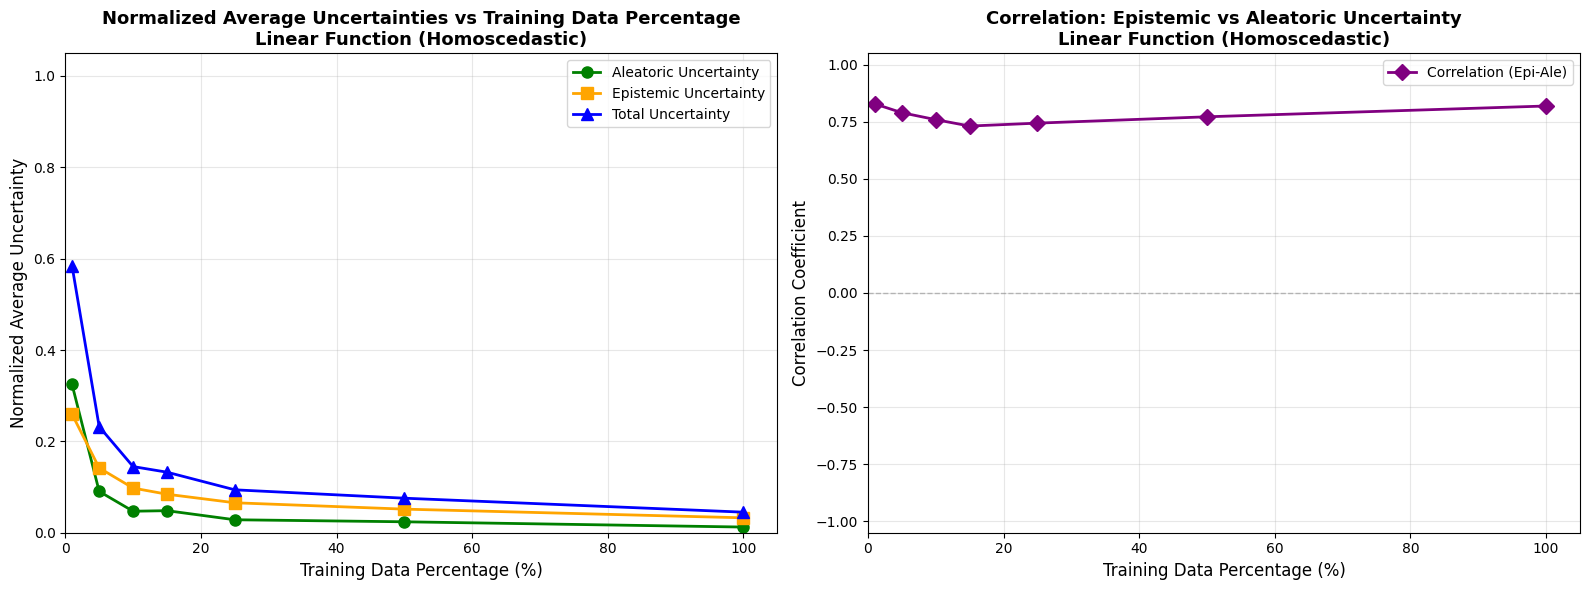


################################################################################
# Function Type: Polynomial (non-linear)
################################################################################



ValueError: type must be 'linear', 'sin'

In [ ]:
# Loop through different function types: linear, non-linear, sin
function_types = ["linear", "non-linear", "sin"]
function_names = {"linear": "Linear", "non-linear": "Polynomial", "sin": "Sinusoidal"}

for func_type in function_types:
    print(f"\n{'#'*80}")
    print(f"# Function Type: {function_names[func_type]} ({func_type})")
    print(f"{'#'*80}\n")
    
    # Loop through different training data amounts: 1%, 5%, 10%, 15%, 50%, 100%
    # Generate full training dataset using generate_toy_regression function
    np.random.seed(42)
    torch.manual_seed(42)

    # Generate training dataset
    x_train_full, y_train_full, x_grid, y_grid_clean = generate_toy_regression(
        n_train=1000, 
        train_range=(10, 30), 
        grid_points=600,
        noise_type='homoscedastic',
        type=func_type
    )

    # Training data percentages to test
    percentages = [1, 5, 10, 15, 25, 50, 100]
      
    # Main loop: train and evaluate for each percentage
    n_train_full = len(x_train_full)

    # Store uncertainties for each percentage
    uncertainties_by_pct = {pct: {'ale': [], 'epi': [], 'tot': []} for pct in percentages}

    for pct in percentages:
        print(f"\n{'='*60}")
        print(f"Training with {pct}% of training data ({int(n_train_full * pct / 100)} samples)")
        print(f"{'='*60}")
        
        # Set seed for reproducibility of subsampling and training
        np.random.seed(42)
        torch.manual_seed(42)
        
        # Subsample training data
        n_samples = int(n_train_full * pct / 100)
        indices = np.random.choice(n_train_full, size=n_samples, replace=False)
        x_train_subset = x_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # Create dataloader
        ds = TensorDataset(torch.from_numpy(x_train_subset), torch.from_numpy(y_train_subset))
        loader = DataLoader(ds, batch_size=32, shuffle=True)
        
        # Train MC Dropout model with beta-NLL (β=0.5)
        model = MCDropoutRegressor(p=0.1)
        train_model(model, loader, epochs=700, lr=1e-3, loss_type='beta_nll', beta=0.5)
        
        # Make predictions
        mu_pred, ale_var, epi_var, tot_var = mc_dropout_predict(model, x_grid, M=20)
        
        # Store uncertainties (using variance values)
        uncertainties_by_pct[pct]['ale'].append(ale_var)
        uncertainties_by_pct[pct]['epi'].append(epi_var)
        uncertainties_by_pct[pct]['tot'].append(tot_var)
    
        # Plot uncertainties
        plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_grid_clean, 
                                 mu_pred, ale_var, epi_var, tot_var, 
                                 title=f"MC Dropout (β-NLL, β=0.5) - {function_names[func_type]} - {pct}% training data",
                                 noise_type='homoscedastic', func_type=func_type)

    # Normalize and compute averages for each percentage
    print(f"\n{'='*60}")
    print(f"Normalized Average Uncertainties by Percentage - {function_names[func_type]} Function")
    print(f"{'='*60}")

    # First, collect all values to compute global min/max for normalization
    all_ale = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['ale']) for pct in percentages])
    all_epi = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['epi']) for pct in percentages])
    all_tot = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['tot']) for pct in percentages])

    # Compute min and max for normalization
    ale_min, ale_max = all_ale.min(), all_ale.max()
    epi_min, epi_max = all_epi.min(), all_epi.max()
    tot_min, tot_max = all_tot.min(), all_tot.max()

    # Normalize function
    def normalize(values, vmin, vmax):
        """Normalize values to [0, 1] range"""
        if vmax - vmin == 0:
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    # Compute and print normalized averages and correlations for each percentage
    print(f"\n{'Percentage':<12} {'Avg Aleatoric (norm)':<25} {'Avg Epistemic (norm)':<25} {'Avg Total (norm)':<25} {'Correlation (Epi-Ale)':<25}")
    print("-" * 120)

    # Store averages and correlations for plotting
    avg_ale_norm_list = []
    avg_epi_norm_list = []
    avg_tot_norm_list = []
    correlation_list = []

    for pct in percentages:
        # Get uncertainties for this percentage
        ale_vals = np.concatenate(uncertainties_by_pct[pct]['ale'])
        epi_vals = np.concatenate(uncertainties_by_pct[pct]['epi'])
        tot_vals = np.concatenate(uncertainties_by_pct[pct]['tot'])
        
        # Normalize
        ale_norm = normalize(ale_vals, ale_min, ale_max)
        epi_norm = normalize(epi_vals, epi_min, epi_max)
        tot_norm = ale_norm + epi_norm
        
        # Compute averages
        avg_ale_norm = np.mean(ale_norm)
        avg_epi_norm = np.mean(epi_norm)
        avg_tot_norm = np.mean(tot_norm)
        
        # Compute correlation between epistemic and aleatoric uncertainties
        # Use original (non-normalized) values for correlation
        correlation = np.corrcoef(epi_vals, ale_vals)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0  # Handle case where std is zero
        
        # Store for plotting
        avg_ale_norm_list.append(avg_ale_norm)
        avg_epi_norm_list.append(avg_epi_norm)
        avg_tot_norm_list.append(avg_tot_norm)
        correlation_list.append(correlation)
    
        print(f"{pct:>3}%        {avg_ale_norm:>24.6f}  {avg_epi_norm:>24.6f}  {avg_tot_norm:>24.6f}  {correlation:>24.6f}")

    print(f"\n{'='*60}")
    print("Note: Average values are normalized to [0, 1] range across all percentages")
    print("      Correlation is computed on original (non-normalized) uncertainty values")
    print(f"{'='*60}")

    # Save summary statistics and create summary plot
    stats_df, fig = save_summary_statistics(
        percentages, avg_ale_norm_list, avg_epi_norm_list, 
        avg_tot_norm_list, correlation_list, 
        function_names[func_type], 
        noise_type='homoscedastic',
        func_type=func_type
    )
    plt.show()
    plt.close(fig)

### Esemble

In [ ]:


# ----- Run end-to-end -----
def main():
    # Data - 1000 samples
    x_train, y_train, x_grid, y_clean = generate_toy_regression(
        n_train=1000,
        train_range=(0.0, 10.0),
        noise_type='heteroscedastic'
    )

    # Train ensemble with NLL
    ens_nll = train_ensemble(x_train, y_train, batch_size=32, K=5, loss_type='nll', beta=0.5)
    mu_nll, ale_nll, epi_nll, tot_nll = ensemble_predict(ens_nll, x_grid)
    plot_uncertainties_no_ood(x_train, y_train, x_grid, y_clean, mu_nll, ale_nll, epi_nll, tot_nll, 
                             title="Ensembles (NLL)", noise_type='heteroscedastic')

    # Train ensemble with β-NLL (β=0.5)
    ens_bnll = train_ensemble(x_train, y_train, batch_size=32, K=5, loss_type='beta_nll', beta=0.5)
    mu_bnll, ale_bnll, epi_bnll, tot_bnll = ensemble_predict(ens_bnll, x_grid)
    plot_uncertainties_no_ood(x_train, y_train, x_grid, y_clean, mu_bnll, ale_bnll, epi_bnll, tot_bnll, 
                             title="Ensembles (β-NLL, β=0.5)", noise_type='heteroscedastic')

if __name__ == "__main__":
    main()


